In [ ]:
# !pip install darts
!pip install statsmodels
!pip install seaborn
!pip install sklearn
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore
# from darts import TimeSeries
# from darts.models import TCNModel
# from darts.dataprocessing.transformers import Scaler
# from darts.metrics import mape
# from darts.utils.timeseries_generation import datetime_attribute_timeseries
# from darts.utils.utils import SeasonalityMode

In [6]:
from darts.explainability.tft_explainer import TFTExplainer
from darts.models import TFTModel
from darts import TimeSeries

C:\Users\abood\miniconda3\envs\ml-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Load data
file_path = "Datasets-with-cloud/amman_Ready.csv"
df = pd.read_csv(file_path)
df.rename(columns={"Unnamed: 0": "Datetime"}, inplace=True)
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.set_index("Datetime", inplace=True)
df = df.asfreq("h")

# # Plot sample
# df[["Air Temperature (OC)"]].plot(figsize=(12, 4), title="Hourly Air Temperature")
# plt.tight_layout()
# plt.show()

In [8]:
df.drop(['Cloud Cover %'], axis = 1, inplace = True)

In [5]:
df.head()

Air Dew Point  Air Temperature (OC)  Humidity %  \
Datetime                                                               
2000-01-01 00:00:00           -2.0                   9.8       43.63   
2000-01-01 01:00:00           -2.0                   9.0       46.04   
2000-01-01 02:00:00           -2.0                   9.0       46.04   
2000-01-01 03:00:00           -3.1                   5.2       55.05   
2000-01-01 04:00:00           -3.0                   4.0       60.31   

                     Atmospheric Pressure  Wind_U  Wind_V  
Datetime                                                   
2000-01-01 00:00:00                1016.1    -0.0     0.0  
2000-01-01 01:00:00                1016.1    -0.0     0.0  
2000-01-01 02:00:00                1016.1    -0.0     0.0  
2000-01-01 03:00:00                1017.1    -0.0     0.0  
2000-01-01 04:00:00                1017.1    -0.0     0.0

In [9]:
from scipy.stats.mstats import winsorize
for col in df.columns:
    df[col] = winsorize(df[col], limits=[0.01, 0.01])

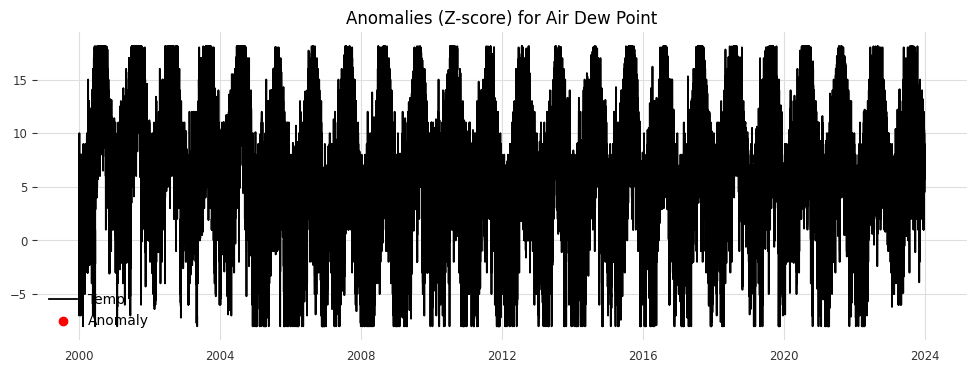

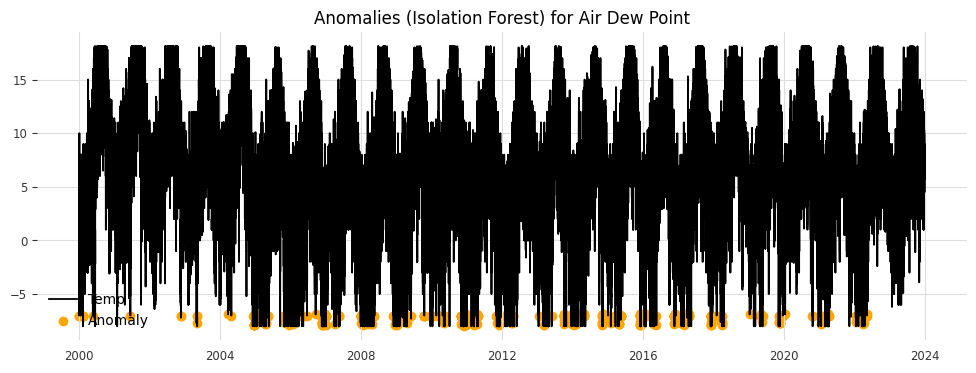

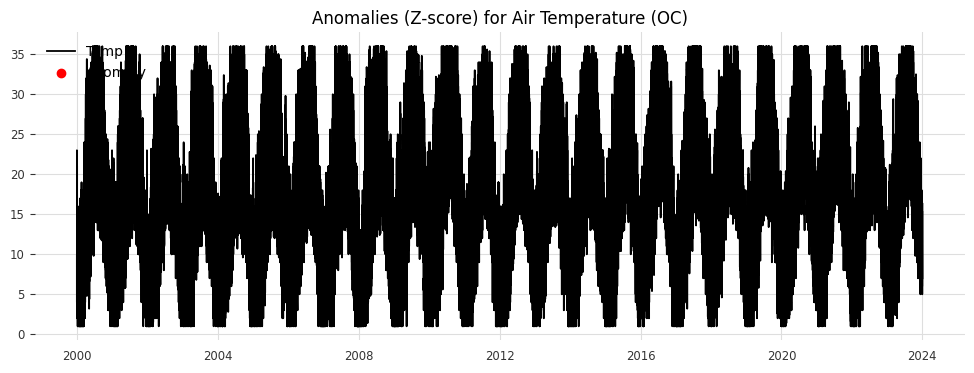

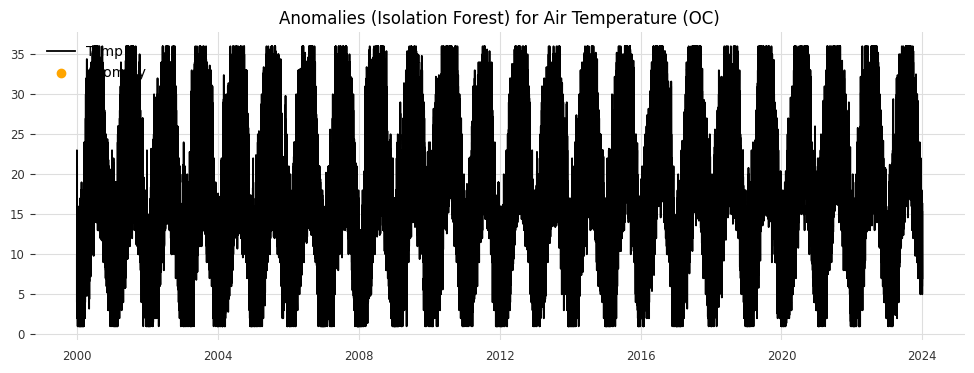

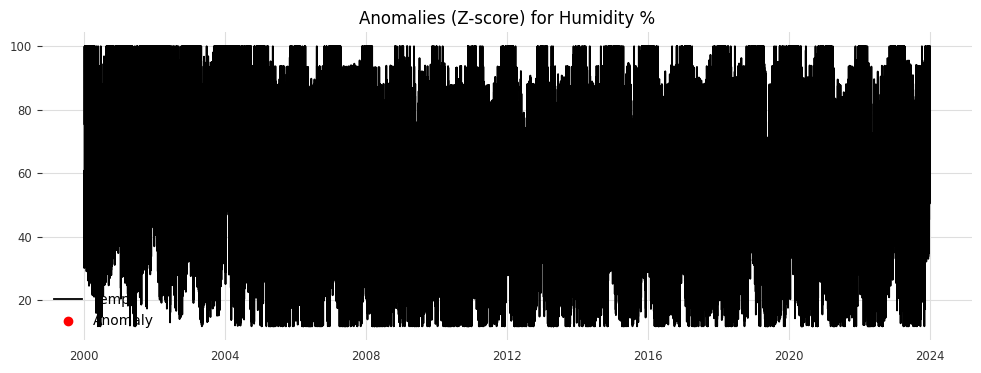

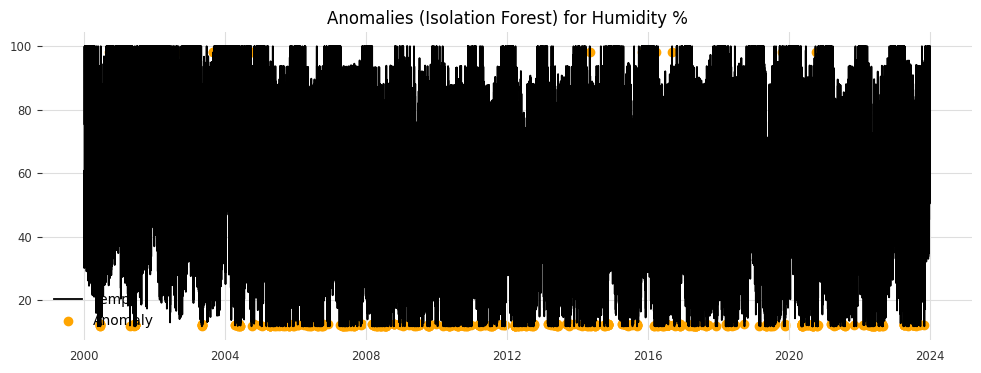

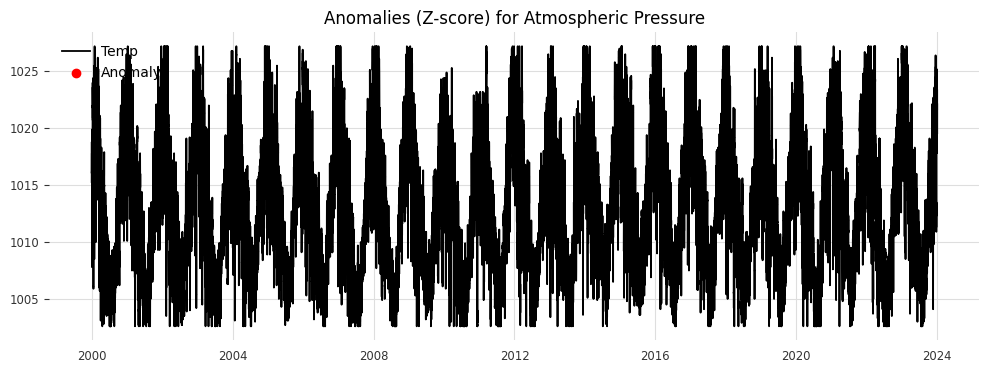

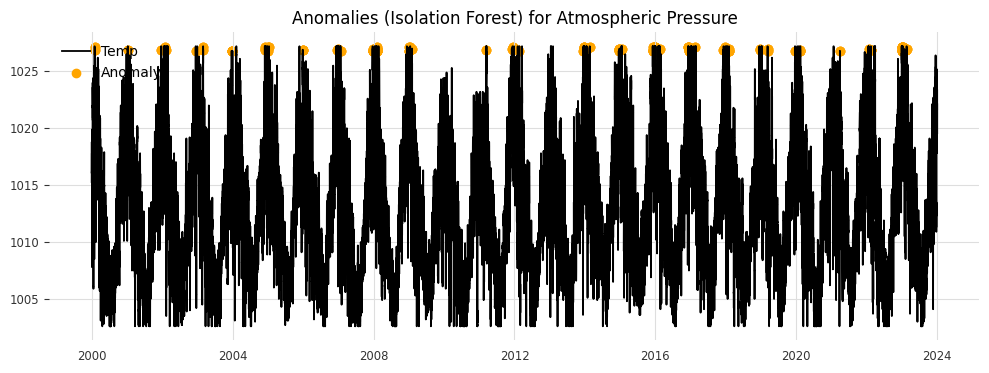

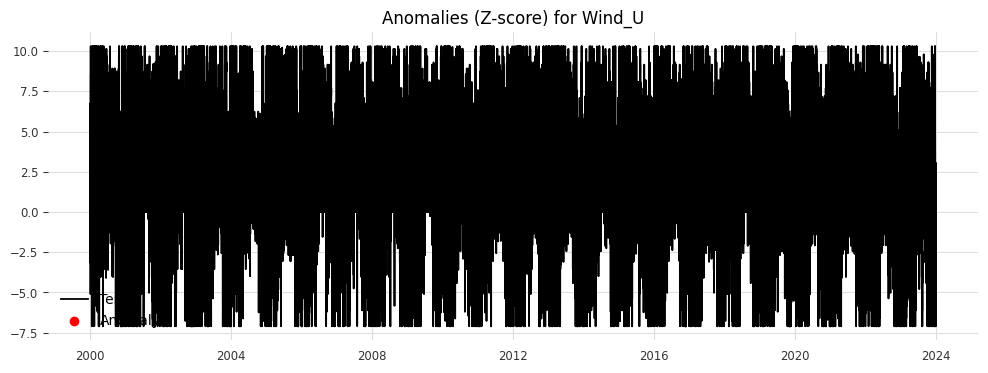

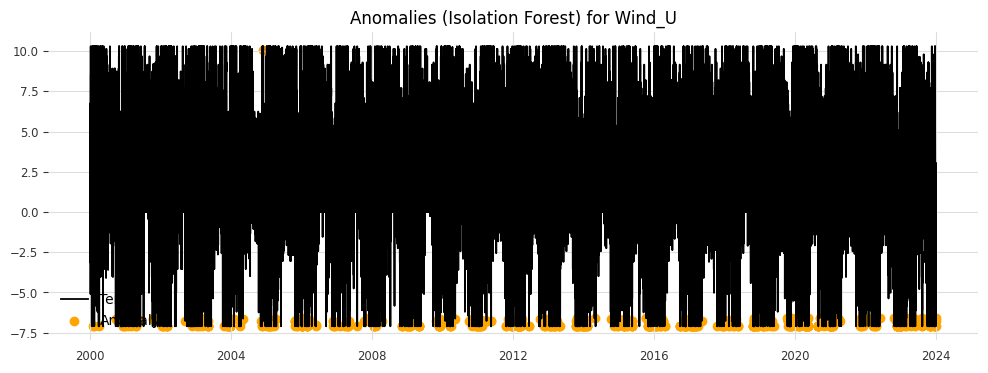

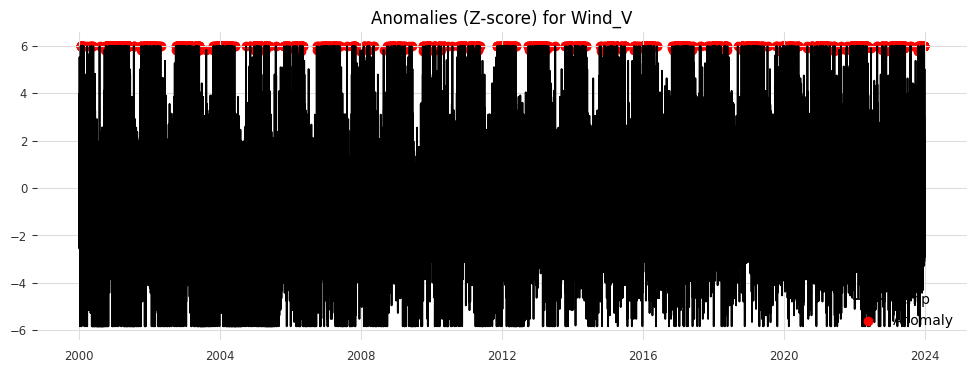

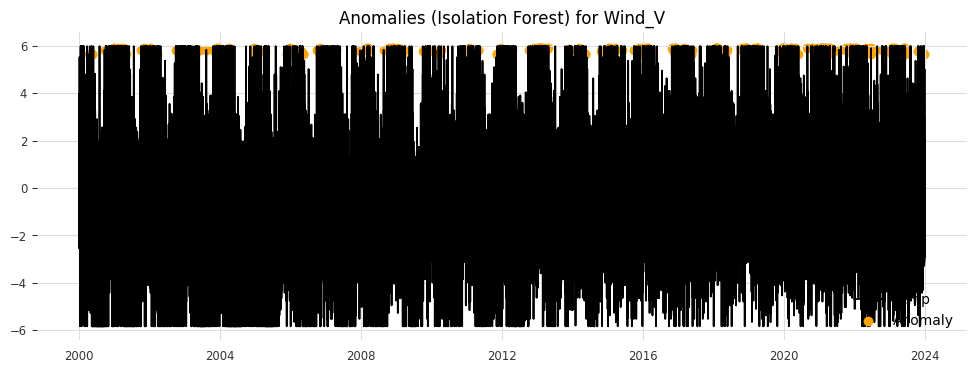

In [6]:
for col in df.columns:
    z_scores = zscore(df[col].dropna())
    anomalies = np.abs(z_scores) > 3
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df[col], label="Temp")
    plt.scatter(df.index[anomalies], df[col][anomalies], color='red', label='Anomaly')
    plt.title(f"Anomalies (Z-score) for {col}")
    plt.legend()
    plt.show()

    iso_df = df[col].dropna()
    iso = IsolationForest(contamination=0.01, random_state=42)
    iso_preds = iso.fit_predict(iso_df.values.reshape(-1, 1))
    iso_anomalies = iso_preds == -1
    plt.figure(figsize=(12, 4))
    plt.plot(iso_df.index, iso_df, label="Temp")
    plt.scatter(iso_df.index[iso_anomalies], iso_df[iso_anomalies], color='orange', label='Anomaly')
    plt.title(f"Anomalies (Isolation Forest) for {col}")
    plt.legend()
    plt.show()

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[df.columns] =  scaler.fit_transform(df[df.columns])


In [12]:
df.columns

Index(['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
       'Atmospheric Pressure', 'Wind_U', 'Wind_V'],
      dtype='object')

# m1

In [53]:
#ملاحظة: هاي العملية بتوخذ كثير رامات، ولازم نلاقيلها حل !!! مثلا نقلل الكونتكست
def data_loader(data, sequence_length):

    input_data = []
    target_data = []

    for i in range(len(data) - sequence_length):
        past_data = data.iloc[i:i + sequence_length][df.columns].values.tolist()
        target_value = data.iloc[i + sequence_length][df.columns]

        input_data.append(past_data)
        target_data.append(target_value)
    return np.array(input_data), np.array(target_data)

In [54]:
X, y = data_loader(df, sequence_length=24)

In [15]:
#هاي القيم هي الfeatures
print(X[0].shape)
print(len(X))
print(X[0])


(24, 6)
210360
[[0.22988506 0.25142857 0.36110167 0.54878049 0.40804598 0.49364945]
 [0.22988506 0.22857143 0.38841664 0.54878049 0.40804598 0.49364945]
 [0.22988506 0.22857143 0.38841664 0.54878049 0.40804598 0.49364945]
 [0.18773946 0.12       0.4905361  0.58943089 0.40804598 0.49364945]
 [0.19157088 0.08571429 0.55015301 0.58943089 0.40804598 0.49364945]
 [0.26819923 0.14285714 0.55582002 0.58943089 0.40804598 0.49364945]
 [0.29885057 0.21142857 0.48656919 0.65853659 0.40804598 0.49364945]
 [0.42145594 0.4        0.37096226 0.65853659 0.40804598 0.49364945]
 [0.49808429 0.48571429 0.34614077 0.65853659 0.31551724 0.60795936]
 [0.50191571 0.56285714 0.27484982 0.60162602 0.29482759 0.55461473]
 [0.49808429 0.6        0.24096112 0.60162602 0.26781609 0.56900931]
 [0.49808429 0.62857143 0.2188598  0.60162602 0.26091954 0.53175275]
 [0.46743295 0.61714286 0.20797915 0.51219512 0.25402299 0.62489416]
 [0.45977011 0.6        0.21568627 0.51219512 0.22758621 0.71718882]
 [0.45977011 0.6   

In [16]:
print(y[0])
print(y[0].shape)


[0.04980843 0.14285714 0.31633231 0.56504065 0.40804598 0.49364945]
(6,)


In [ ]:
len(df)*0.8


168307.2

In [55]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
test_size = len(X) - train_size - val_size

print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print(X_train.shape, y_train.shape)
print(X_val.shape)
print(X_test.shape)

Train size: 168288, Validation size: 21036, Test size: 21036
(168288, 24, 6) (168288, 6)
(21036, 24, 6)
(21036, 24, 6)


In [56]:
import torch
import torch.nn as nn
import torch.optim as optim

class TempPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(TempPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [57]:
input_size = 6  # Number of features
hidden_size = 128  # LSTM hidden units
num_layers = 6  # Number of LSTM layers
output_size = 6  # Predicting 6 values

model = TempPredictor(input_size, hidden_size, num_layers, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

TempPredictor(
  (lstm): LSTM(6, 128, num_layers=6, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


In [20]:
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)#.unsqueeze(1)  # Add dimension for MSE loss

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)#.unsqueeze(1)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TempPredictor(
  (lstm): LSTM(6, 128, num_layers=6, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the device
model = model.to(device)

train_losses = []
val_losses = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    # Store loss for plotting
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

print("Training complete!")


Using device: cuda
Epoch 1/10, Train Loss: 0.0361, Val Loss: 0.0833
Epoch 2/10, Train Loss: 0.0385, Val Loss: 0.0831
Epoch 3/10, Train Loss: 0.0364, Val Loss: 0.0819
Epoch 4/10, Train Loss: 0.0358, Val Loss: 0.0827
Epoch 5/10, Train Loss: 0.0365, Val Loss: 0.0818
Epoch 6/10, Train Loss: 0.0368, Val Loss: 0.0798
Epoch 7/10, Train Loss: 0.0366, Val Loss: 0.0814
Epoch 8/10, Train Loss: 0.0371, Val Loss: 0.0814
Epoch 9/10, Train Loss: 0.0361, Val Loss: 0.0802
Epoch 10/10, Train Loss: 0.0388, Val Loss: 0.0819
Training complete!


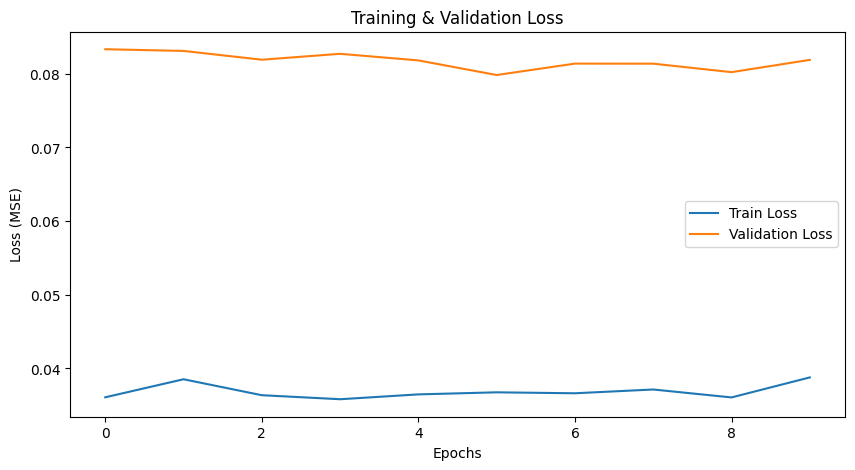

In [22]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)  # Ensure shape compatibility

model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

y_pred = y_pred_tensor.cpu().numpy().flatten()
y_test = y_test_tensor.cpu().numpy().flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Mean Absolute Percentage Error

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Percentage Error (MAPE): inf%
Mean Absolute Error (MAE): 0.2211
Root Mean Squared Error (RMSE): 0.2769


C:\Users\abood\AppData\Local\Temp\ipykernel_7928\1156814127.py:15: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Mean Absolute Percentage Error


In [24]:
# Assume y_pred and y_test are both shaped [N, 6]
# If not, reshape them accordingly:
y_pred_reshaped = y_pred.reshape(-1, 6)
y_test_reshaped = y_test.reshape(-1, 6)

# Direct inverse transform since all columns are present
y_pred_rescaled = scaler.inverse_transform(y_pred_reshaped)
y_test_rescaled = scaler.inverse_transform(y_test_reshaped)

# y_pred_reshaped = y_pred.reshape(-1, 6)  # Reshape to 2D
# y_test_reshaped = y_test.reshape(-1, 6)
# dummy_array = np.zeros((len(y_pred), 6))
# dummy_array[:, 2] = y_pred_reshaped.flatten()  # Assign values to the 3rd column (temp)
# # Inverse transform using the scaler
# y_pred_rescaled = scaler.inverse_transform(dummy_array)[:, 2]  # Extract only the temp column
# # Do the same for y_test
# dummy_array[:, 2] = y_test_reshaped.flatten()  # Assign values to the 3rd column (temp)
# y_test_rescaled = scaler.inverse_transform(dummy_array)[:, 2]  # Extract only the temp column

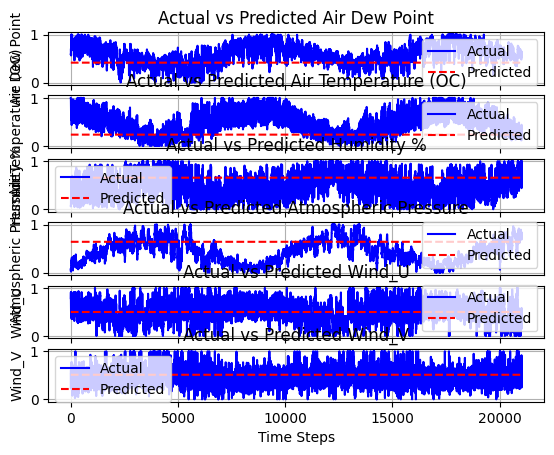

In [25]:
for i, target in enumerate(df.columns):
    plt.subplot(6, 1, i + 1)
    plt.plot(y_test_reshaped[:, i], label='Actual', color='blue')
    plt.plot(y_pred_reshaped[:, i], label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted {target}')
    plt.xlabel('Time Steps')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)

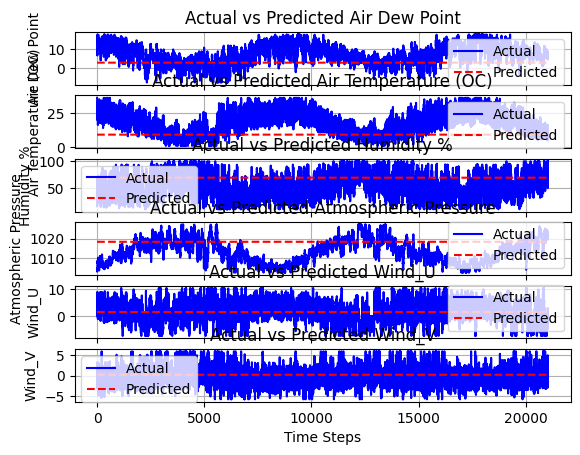

In [26]:
for i, target in enumerate(df.columns):
    plt.subplot(6, 1, i + 1)
    plt.plot(y_test_rescaled[:, i], label='Actual', color='blue')
    plt.plot(y_pred_rescaled[:,i], label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted {target}')
    plt.xlabel('Time Steps')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)

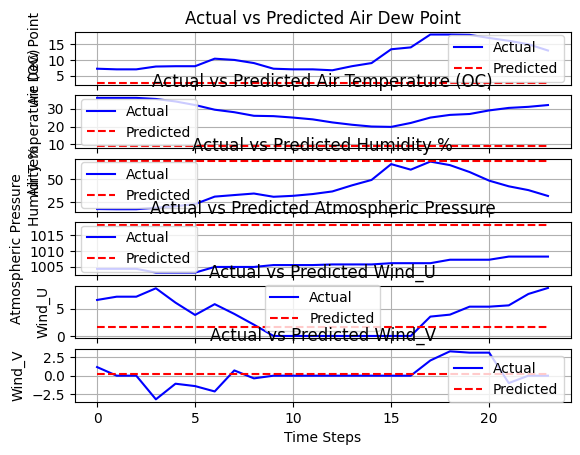

In [27]:
for i, target in enumerate(df.columns):
    plt.subplot(6, 1, i + 1)
    plt.plot(y_test_rescaled[:24, i], label='Actual', color='blue')
    plt.plot(y_pred_rescaled[:24,i], label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted {target}')
    plt.xlabel('Time Steps')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)

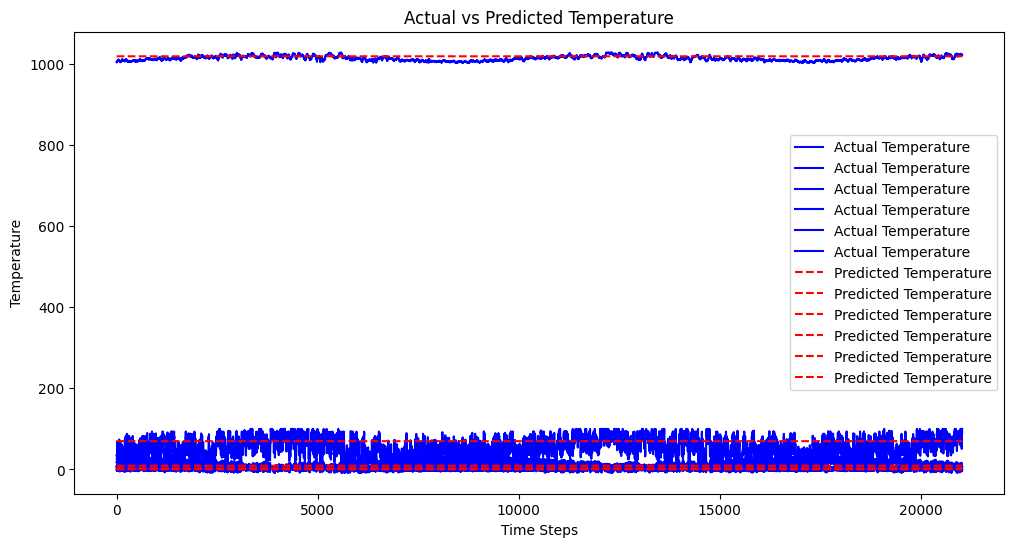

In [29]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Temperature", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Temperature", color="red", linestyle="dashed")
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.legend()
plt.title("Actual vs Predicted Temperature")
plt.show()

In [30]:
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100  # Mean Absolute Percentage Error

# Print results
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Percentage Error (MAPE): 598706700.00%
Mean Absolute Error (MAE): 8.2329
Root Mean Squared Error (RMSE): 12.9824


In [ ]:
y_test_rescaled[:24]

array([[ 7.19999886e+00,  3.60000038e+01,  1.70886726e+01,
         1.00430005e+03,  6.59999990e+00,  1.16000032e+00],
       [ 7.00000048e+00,  3.60000038e+01,  1.68562870e+01,
         1.00430005e+03,  7.20000029e+00, -1.59740452e-07],
       [ 7.00000048e+00,  3.60000038e+01,  1.68562870e+01,
         1.00430005e+03,  7.20000029e+00, -1.59740452e-07],
       [ 7.90000057e+00,  3.54000015e+01,  1.85273113e+01,
         1.00309998e+03,  8.74000072e+00, -3.17999983e+00],
       [ 8.00000000e+00,  3.40000000e+01,  2.01617775e+01,
         1.00309998e+03,  6.10999966e+00, -1.08000004e+00],
       [ 8.00000000e+00,  3.20000000e+01,  2.25610027e+01,
         1.00309998e+03,  3.85000038e+00, -1.39999998e+00],
       [ 1.03999996e+01,  2.93999996e+01,  3.07669125e+01,
         1.00490002e+03,  5.82999992e+00, -2.12000012e+00],
       [ 1.00000000e+01,  2.80000000e+01,  3.24901161e+01,
         1.00490002e+03,  4.03999996e+00,  7.09999740e-01],
       [ 9.00000095e+00,  2.60000000e+01,  3.416

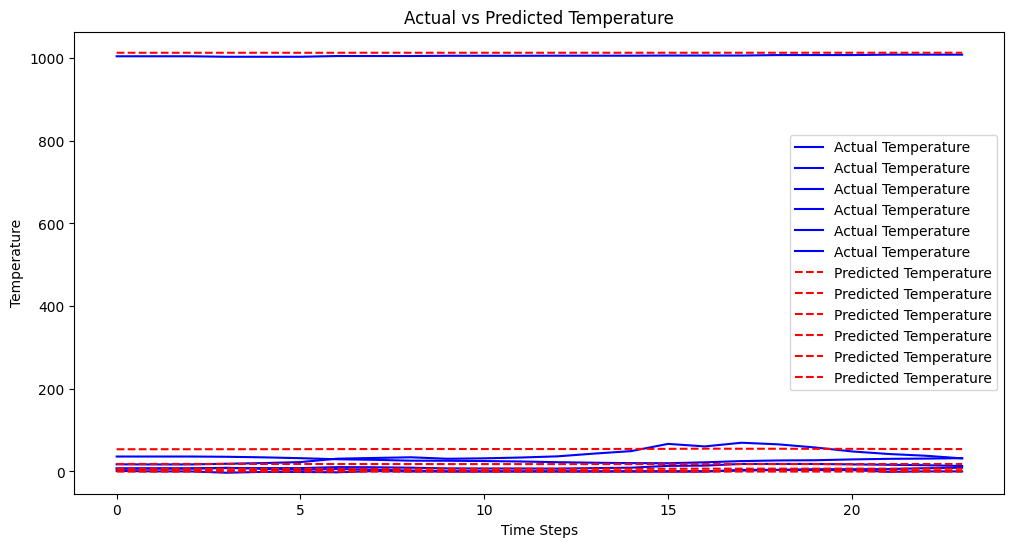

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:24], label="Actual Temperature", color="blue")
plt.plot(y_pred_rescaled[:24], label="Predicted Temperature", color="red", linestyle="dashed")
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.legend()
plt.title("Actual vs Predicted Temperature")
plt.show()

# m2

In [ ]:
# 1️⃣ Create Date-Based Features

# df["YEAR"] = df["DATE"].dt.year
# df["MONTH"] = df["DATE"].dt.month
# df["DAY_OF_YEAR"] = df["DATE"].dt.dayofyear
# df["QUARTER"] = df["DATE"].dt.quarter
# df["WEEK_OF_YEAR"] = df["DATE"].dt.isocalendar().week
# df["DAY_OF_WEEK"] = df["DATE"].dt.dayofweek

# df.head()

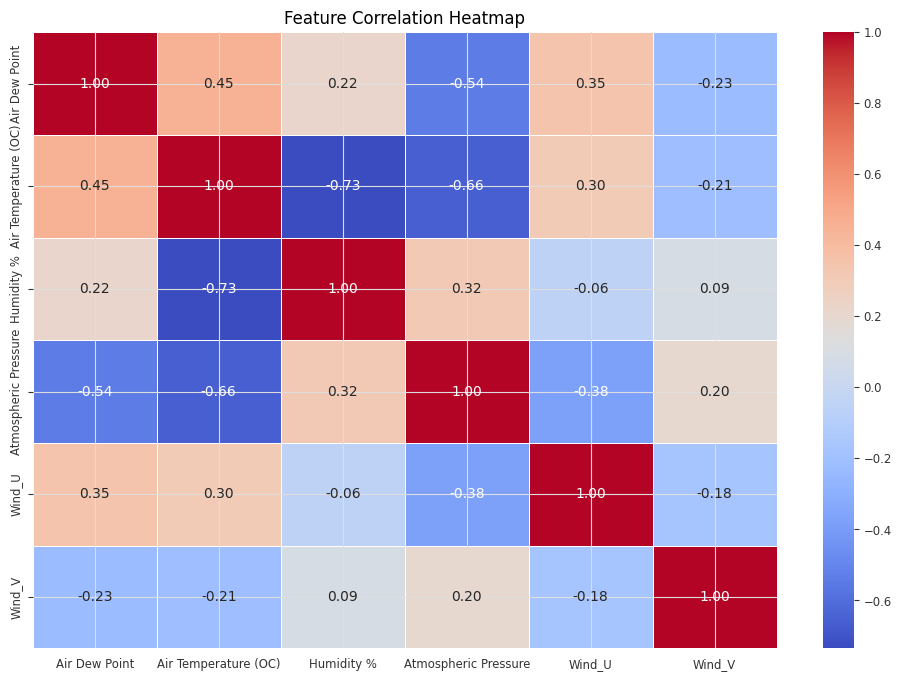

In [ ]:
# Feature Selection Methods
# We'll use three approaches to identify the most relevant features:
# 1️⃣ Correlation Matrix (Heatmap) → Removes highly correlated features.
# 2️⃣ XGBoost Feature Importance → Uses tree-based ranking.
# 3️⃣ SHAP (Shapley Additive Explanations) → Measures the impact of each feature on predictions.

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

<Figure size 1200x800 with 0 Axes>

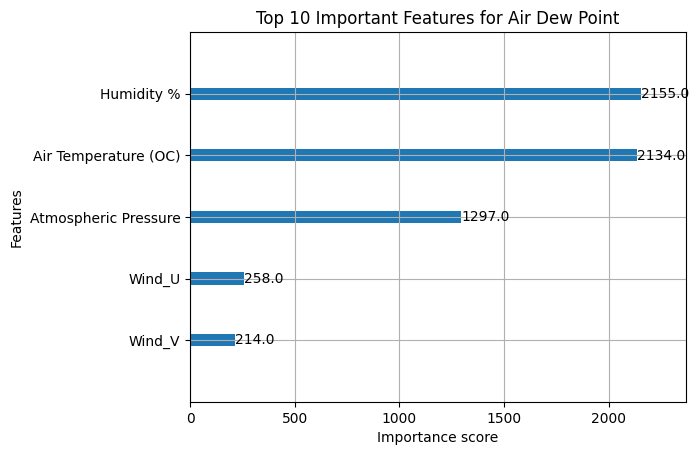

<Figure size 1200x800 with 0 Axes>

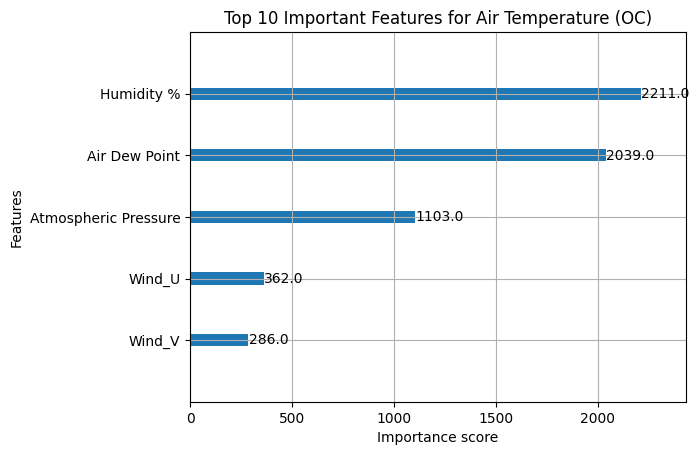

<Figure size 1200x800 with 0 Axes>

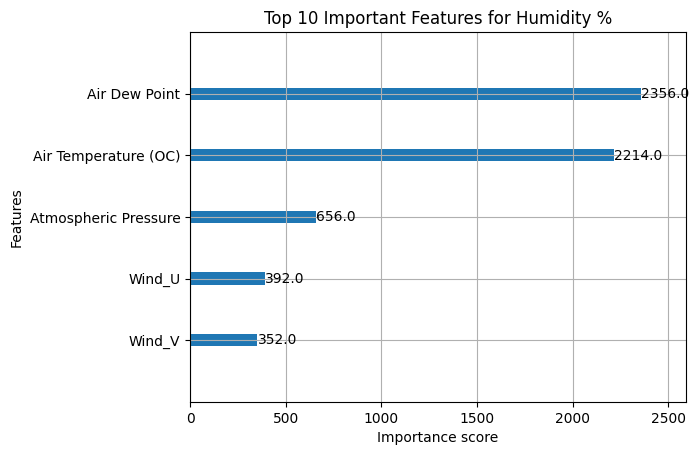

<Figure size 1200x800 with 0 Axes>

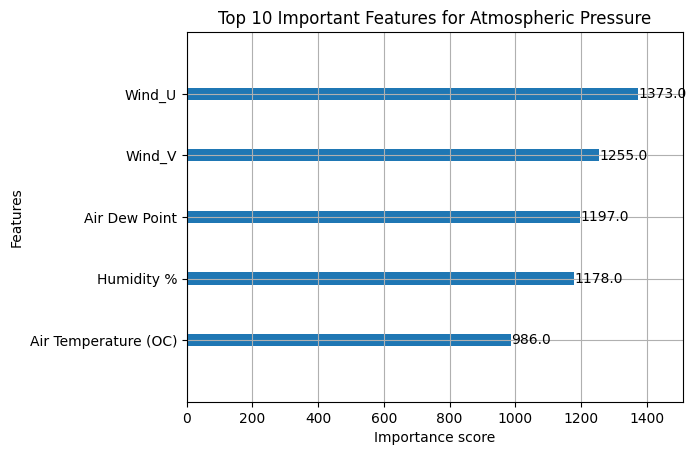

<Figure size 1200x800 with 0 Axes>

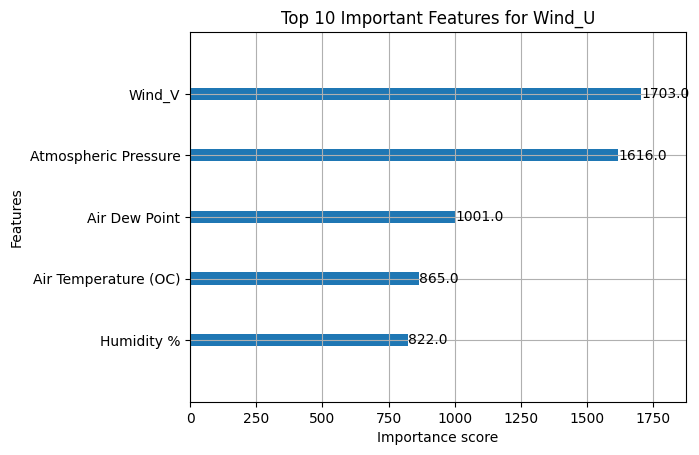

<Figure size 1200x800 with 0 Axes>

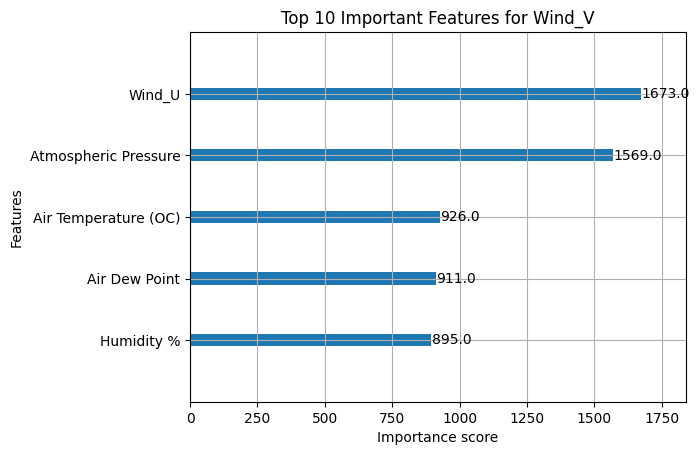

In [31]:
import xgboost as xgb
import matplotlib.pyplot as plt

for col in df.columns:
  X = df.drop(columns=[col])  # Drop target variable
  y = df[col]
  xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
  xgb_model.fit(X, y)
  plt.figure(figsize=(12, 8))
  xgb.plot_importance(xgb_model, importance_type="weight", max_num_features=10)
  plt.title(f"Top 10 Important Features for {col}")
  plt.show()



In [58]:
from sklearn.model_selection import train_test_split

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


Model Air Dew Point training completed successfully!
Model Performance Metrics:
Mean Absolute Error (MAE): 0.0067
Mean Squared Error (MSE): 0.0002
Root Mean Squared Error (RMSE): 0.0138
R² Score: 0.9960


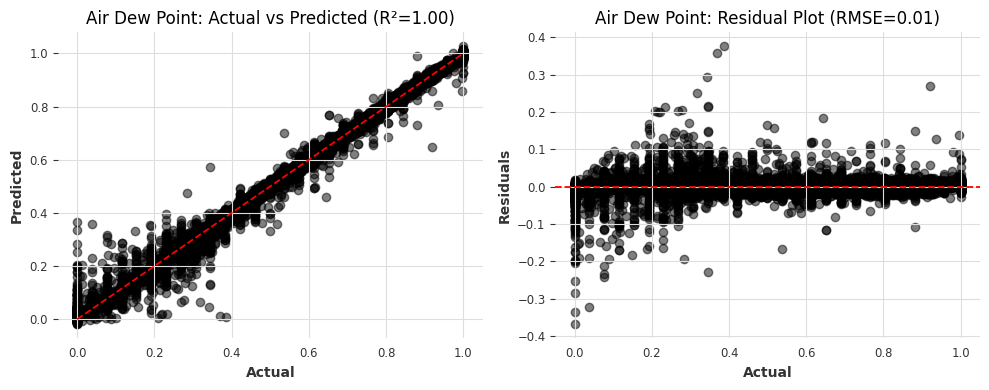

Model Air Temperature (OC) training completed successfully!
Model Performance Metrics:
Mean Absolute Error (MAE): 0.0058
Mean Squared Error (MSE): 0.0002
Root Mean Squared Error (RMSE): 0.0144
R² Score: 0.9967


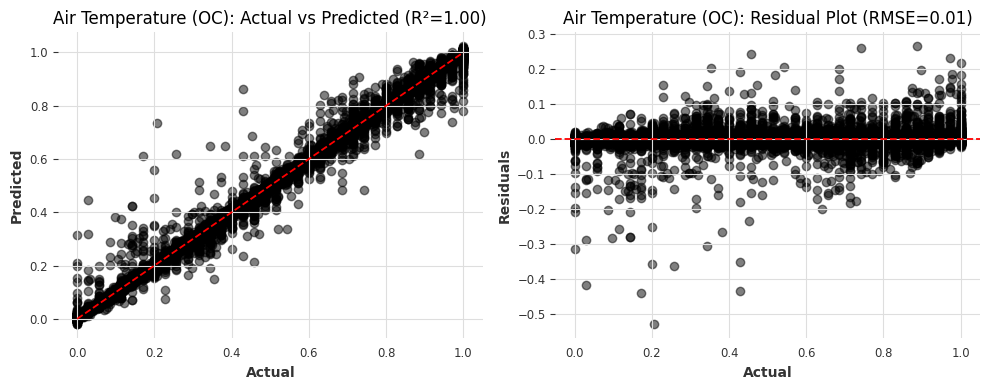

Model Humidity % training completed successfully!
Model Performance Metrics:
Mean Absolute Error (MAE): 0.0067
Mean Squared Error (MSE): 0.0002
Root Mean Squared Error (RMSE): 0.0150
R² Score: 0.9970


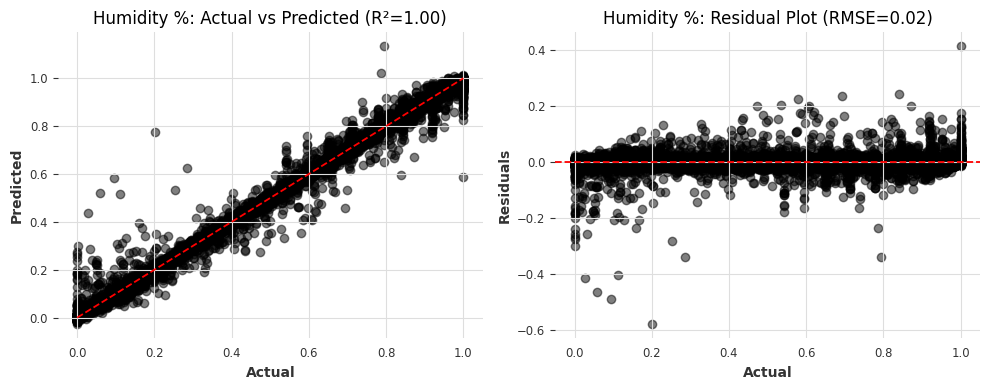

Model Atmospheric Pressure training completed successfully!
Model Performance Metrics:
Mean Absolute Error (MAE): 0.1193
Mean Squared Error (MSE): 0.0226
Root Mean Squared Error (RMSE): 0.1503
R² Score: 0.5928


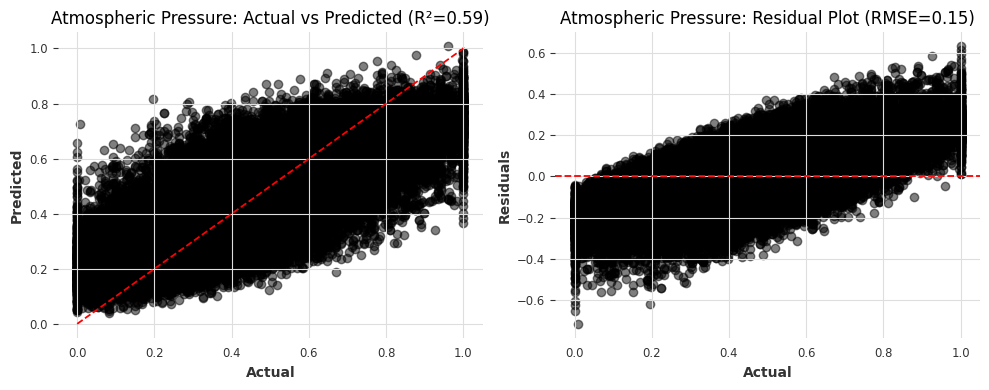

Model Wind_U training completed successfully!
Model Performance Metrics:
Mean Absolute Error (MAE): 0.1011
Mean Squared Error (MSE): 0.0224
Root Mean Squared Error (RMSE): 0.1497
R² Score: 0.4463


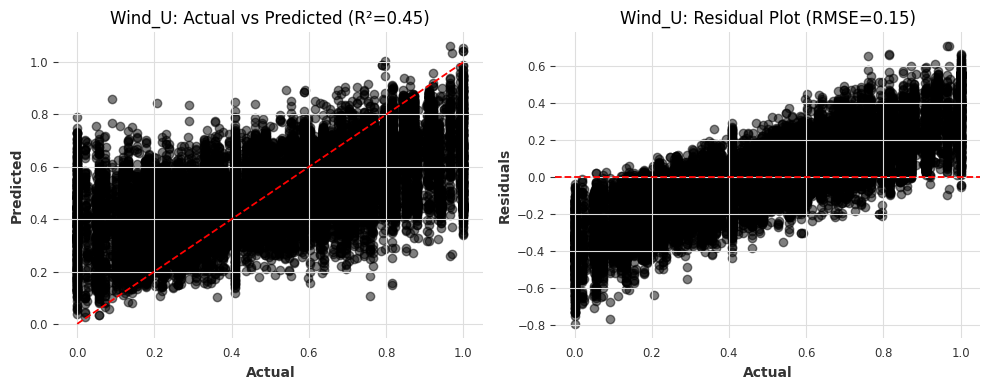

Model Wind_V training completed successfully!
Model Performance Metrics:
Mean Absolute Error (MAE): 0.0900
Mean Squared Error (MSE): 0.0201
Root Mean Squared Error (RMSE): 0.1418
R² Score: 0.3077


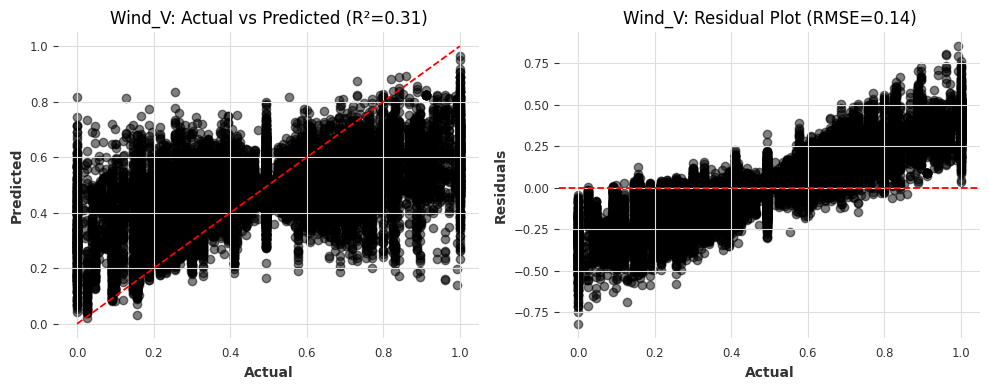

In [60]:
for col in df.columns:
  X = df.drop(columns=[col])  # Features
  y = df[col]  # Target
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  xgb_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'random_state': 42
    }
  model = xgb.XGBRegressor(**xgb_params)
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  print(f"Model {col} training completed successfully!")
  mae = mean_absolute_error(y_test, y_test_pred)
  mse = mean_squared_error(y_test, y_test_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_test_pred)

  # Print results
  print("Model Performance Metrics:")
  print(f"Mean Absolute Error (MAE): {mae:.4f}")
  print(f"Mean Squared Error (MSE): {mse:.4f}")
  print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
  print(f"R² Score: {r2:.4f}")

  # --- Plot 1: True vs Predicted ---
  plt.figure(figsize=(10, 4))

  plt.subplot(1, 2, 1)
  plt.scatter(y_test, y_test_pred, alpha=0.5, edgecolor='k')
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  plt.title(f"{col}: Actual vs Predicted (R²={r2:.2f})")

  # --- Plot 2: Residuals ---
  plt.subplot(1, 2, 2)
  residuals = y_test - y_test_pred
  plt.scatter(y_test, residuals, alpha=0.5, edgecolor='k')
  plt.axhline(0, color='red', linestyle='--')
  plt.xlabel("Actual")
  plt.ylabel("Residuals")
  plt.title(f"{col}: Residual Plot (RMSE={rmse:.2f})")

  plt.tight_layout()
  plt.show()


In [61]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, Input
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [62]:
# Reshape for LSTM (samples, timesteps, features)
X_lstm = X.values.reshape(X.shape[0], 1, X.shape[1])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=0)

In [63]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)


In [64]:
xgb_baseline = xgb.XGBRegressor(
    n_estimators=500, learning_rate=0.02, max_depth=10, colsample_bytree=0.99, gamma=0.000056,
    random_state=42
)

xgb_baseline.fit(X_train.numpy().reshape(X_train.shape[0], X_train.shape[2]), y_train.numpy())
y_pred_xgb = xgb_baseline.predict(X_test.numpy().reshape(X_test.shape[0], X_test.shape[2]))

# Evaluate XGBoost
mae_xgb = mean_absolute_error(y_test.numpy(), y_pred_xgb)
mse_xgb = mean_squared_error(y_test.numpy(), y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test.numpy(), y_pred_xgb)

print(f"XGBoost Performance:\nMAE: {mae_xgb}\nMSE: {mse_xgb}\nRMSE: {rmse_xgb}\nR² Score: {r2_xgb}")

XGBoost Performance:
MAE: 0.0885353833436966
MSE: 0.01997554674744606
RMSE: 0.1413348744912099
R² Score: 0.31770259141921997


In [ ]:
df.columns

Index(['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
       'Atmospheric Pressure', 'Wind_U', 'Wind_V'],
      dtype='object')

# m3

In [ ]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

ts = TimeSeries.from_dataframe(df_feat, value_cols="Air Temperature (OC)")
train, val = ts.split_after(0.85)


train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)


# model = TCNModel(input_chunk_length=24*14, output_chunk_length=24,kernel_size=6,num_filters=1,num_layers=8,dilation_base=2, n_epochs=100, random_state=0, dropout=0.1, weight_norm=False, batch_size = 512)
# model.fit(train_scaled)




<Axes: xlabel='Datetime'>

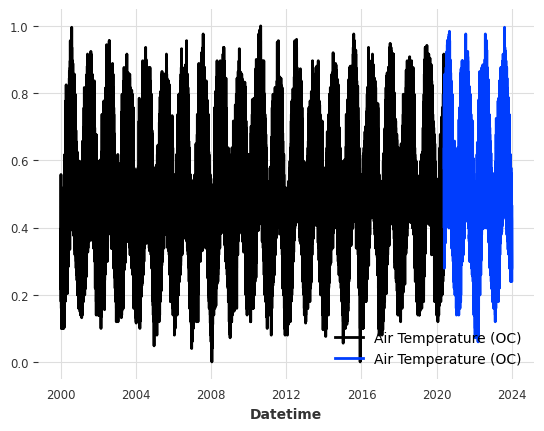

In [ ]:
train_scaled.plot()
val_scaled.plot()

In [40]:
# forecast = model.predict(len(val_scaled))
forecast = model.predict(24)

uforecast = scaler.inverse_transform(forecast)

forecast.plot()

C:\Users\abood\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:1320: UserWarning: Unknown data type: <class 'int'>, trying to convert it to csr_matrix
  warnings.warn(


ValueError: data did not contain feature names, but the following fields are expected: Air Dew Point, Air Temperature (OC), Humidity %, Atmospheric Pressure, Wind_U

<Axes: xlabel='Datetime'>

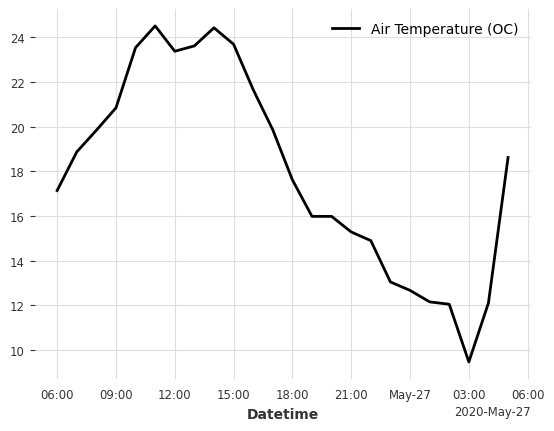

In [ ]:
uforecast.plot()

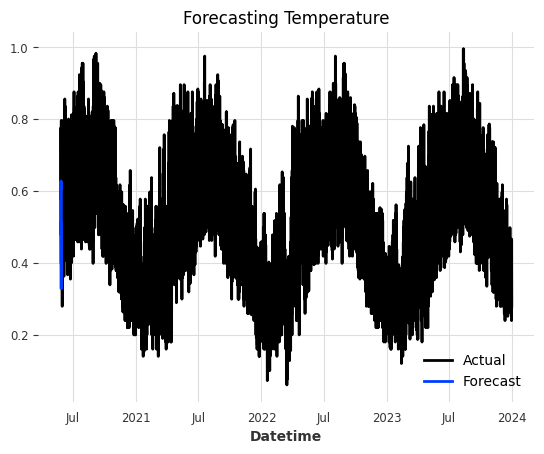

MAE: 22.127511994109312
RMSE: 22.93347540601794


In [ ]:
# train = scaler.inverse_transform(train_scaled)
# val = scaler.inverse_transform(val_scaled)
# Plot forecast
# train_scaled.plot(label="Actual")
val_scaled.plot(label="Actual")
forecast.plot(label="Forecast")
plt.title("Forecasting Temperature")
plt.legend()
plt.show()

from darts.metrics import mae, rmse

print("MAE:", mae(val, forecast))
print("RMSE:", rmse(val, forecast))





In [ ]:
val.start_time()

Timestamp('2020-05-26 06:00:00')

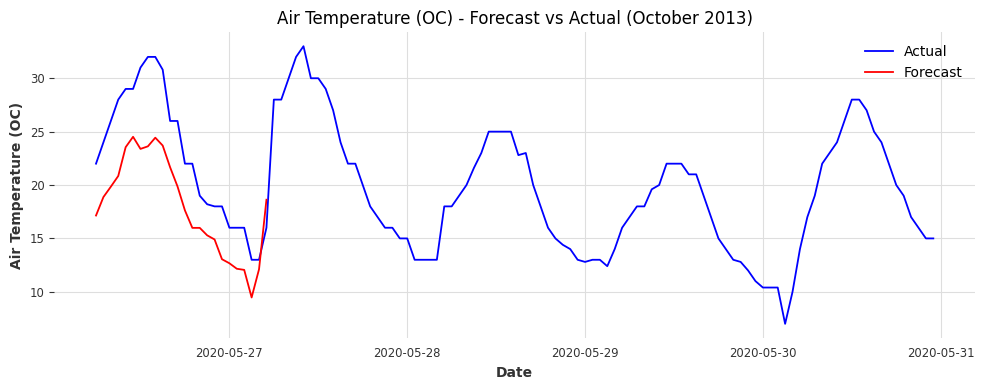

In [ ]:

# Convert TimeSeries objects to pandas DataFrames
forecast_pd = uforecast.to_dataframe()
val_pd = val.to_dataframe()

# Filter data for October 2013
val_2013_10 = val_pd[(val_pd.index.year == 2020) & (val_pd.index.month == 5) & (val_pd.index.day <= 30)]
forecast_2013_10 = forecast_pd[(forecast_pd.index.year == 2020) & (forecast_pd.index.month == 5) & (forecast_pd.index.day <= 30)]

# Plot each column/component
for col in val_2013_10.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(val_2013_10.index, val_2013_10[col], label='Actual', color='blue')
    plt.plot(forecast_2013_10.index, forecast_2013_10[col], label='Forecast', color='red')
    plt.title(f'{col} - Forecast vs Actual (October 2013)')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [66]:
# =============================
# FEATURE ENGINEERING
# =============================

df_feat = df.copy()
df_feat["hour"] = df_feat.index.hour
df_feat["dayofweek"] = df_feat.index.dayofweek
df_feat["month"] = df_feat.index.month
#df_feat["lag_1"] = df_feat["Air Temperature (OC)"].shift(1)
df_feat["rolling_mean_24"] = df_feat["Air Temperature (OC)"].rolling(24).mean()
df_feat["rolling_std_24"] = df_feat["Air Temperature (OC)"].rolling(24).std()
df_feat.dropna(inplace=True)
# Save for ML use
df_feat.dropna().to_csv("weather_features_ready.csv")
print("✅ Feature engineered dataset saved as 'weather_features_ready.csv'")

✅ Feature engineered dataset saved as 'weather_features_ready.csv'


In [67]:
df_feat.head()

Air Dew Point  Air Temperature (OC)  Humidity %  \
Datetime                                                               
2000-01-01 23:00:00       0.191571              0.200000    0.385130   
2000-01-02 00:00:00       0.049808              0.142857    0.316332   
2000-01-02 01:00:00       0.038314              0.142857    0.306132   
2000-01-02 02:00:00       0.038314              0.114286    0.337640   
2000-01-02 03:00:00       0.172414              0.131429    0.455627   

                     Atmospheric Pressure    Wind_U    Wind_V  hour  \
Datetime                                                              
2000-01-01 23:00:00              0.573171  0.408046  0.493649    23   
2000-01-02 00:00:00              0.565041  0.408046  0.493649     0   
2000-01-02 01:00:00              0.565041  0.408046  0.493649     1   
2000-01-02 02:00:00              0.565041  0.408046  0.493649     2   
2000-01-02 03:00:00              0.552846  0.408046  0.493649     3   

                     dayofweek  month  rolling_mean_24  rolling_std_24  
Datetime                                                                
2000-01-01 23:00:00          5      1         0.355833        0.179315  
2000-01-02 00:00:00          6      1         0.351310        0.183387  
2000-01-02 01:00:00          6      1         0.347738        0.186686  
2000-01-02 02:00:00          6      1         0.342976        0.191260  
2000-01-02 03:00:00          6      1         0.343452        0.190694

In [ ]:
model = TFTModel(
    input_chunk_length=12,
    output_chunk_length=6,
    add_encoders={"cyclic": {"future": ["hour"]}},
    n_epochs=20,
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": [0],
        "train_dataloader_config": {"batch_size": 512}
    }
)
model.fit(train_scaled)
# create the explainer and generate explanations
explainer = TFTExplainer(model)
results = explainer.explain()
# plot the results
explainer.plot_attention(results, plot_type="all")
explainer.plot_variable_selection(results)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork      

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

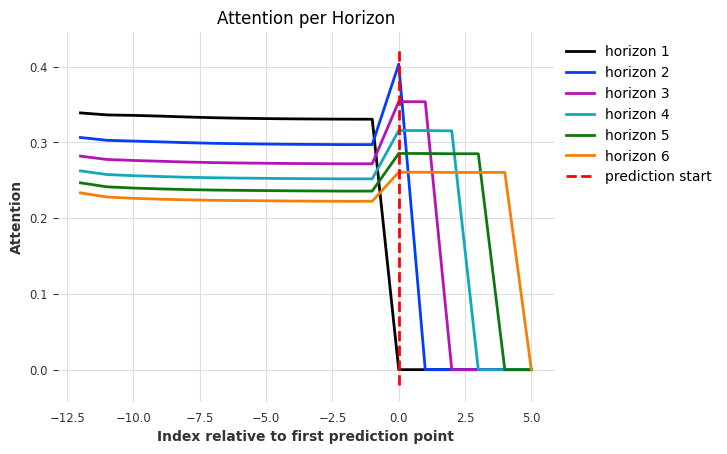

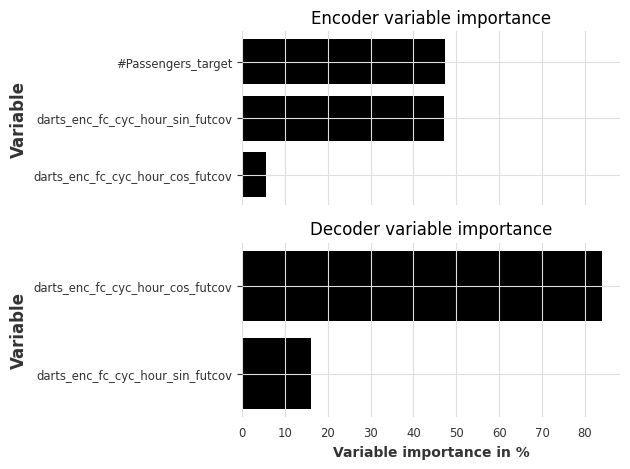

In [ ]:
from darts.datasets import AirPassengersDataset
from darts.explainability.tft_explainer import TFTExplainer
from darts.models import TFTModel
ser = AirPassengersDataset().load()
model = TFTModel(
    input_chunk_length=12,
    output_chunk_length=6,
    add_encoders={"cyclic": {"future": ["hour"]}}
)
model.fit(ser)
# create the explainer and generate explanations
explainer = TFTExplainer(model)
results = explainer.explain()
# plot the results
explainer.plot_attention(results, plot_type="all")
explainer.plot_variable_selection(results)

In [ ]:
# Function to prepare data for time series modeling
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# Function to load and preprocess data
def load_and_preprocess_data(filepath, n_steps=30):
    df = pd.read_csv(filepath, parse_dates=["date"], index_col="date")
    df.sort_index(inplace=True)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['values']])
    X, y = prepare_data(scaled_data, n_steps)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test, scaler

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Conv1D, Dropout

# Generate synthetic data
date_rng = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')
n = len(date_rng)
trend = np.linspace(0, 100, n)
seasonality = 10 * np.sin(2 * np.pi * np.arange(n)/365.25)
noise = np.random.normal(0, 5, n)
y = trend + seasonality + noise
df = pd.DataFrame(data={'date': date_rng, 'value': y})

# Normalize and prepare data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['value']])
X, y = prepare_data(scaled_data, n_steps=30)



In [ ]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense

# Residual block for TCN
def residual_block(x, dilation_rate, filters):
    skip = x
    x = Conv1D(filters, kernel_size=3, dilation_rate=dilation_rate, padding='causal', activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Conv1D(filters, kernel_size=3, dilation_rate=dilation_rate, padding='causal', activation='relu')(x)
    x = Dropout(0.4)(x)
    x = LayerNormalization()(x + skip)
    return x

# Transformer encoder block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [ ]:
# Function to train and evaluate models
def run_models(X_train, X_test, y_train, y_test, n_steps):
    results = {}

    # FNN
    model_fnn = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_steps, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model_fnn.compile(optimizer='adam', loss='mse')
    model_fnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    results['FNN'] = model_fnn.predict(X_test)

    # LSTM
    X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    model_lstm = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_steps, 1)),
        tf.keras.layers.LSTM(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')
    model_lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    results['LSTM'] = model_lstm.predict(X_test_lstm)

    # CNN
    model_cnn = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_steps, 1)),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model_cnn.compile(optimizer='adam', loss='mse')
    model_cnn.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    results['CNN'] = model_cnn.predict(X_test_lstm)

    # TCN
    inputs_tcn = tf.keras.layers.Input(shape=(n_steps, 1))
    x = inputs_tcn
    for i in range(4):
        x = residual_block(x, dilation_rate=2**i, filters=64)
    x = Dense(1)(x[:, -1, :])
    model_tcn = tf.keras.Model(inputs_tcn, x)
    model_tcn.compile(optimizer='adam', loss='mse')
    model_tcn.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    results['TCN'] = model_tcn.predict(X_test_lstm)

    # Transformer
    inputs_transformer = tf.keras.Input(shape=(n_steps, 1))
    x = inputs_transformer
    for _ in range(4):
        x = transformer_encoder(x, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
    x = Dense(1)(x[:, -1, :])
    model_transformer = tf.keras.Model(inputs_transformer, x)
    model_transformer.compile(optimizer='adam', loss='mse')
    model_transformer.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    results['Transformer'] = model_transformer.predict(X_test_lstm)

    return results

In [ ]:
# Function to evaluate and visualize results
def evaluate_and_plot(y_test, results, scaler):
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    predictions_inv = {name: scaler.inverse_transform(pred) for name, pred in results.items()}

    # Plot predictions
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inv, label='True')
    for name, pred in predictions_inv.items():
        plt.plot(pred, label=f'Predicted ({name})')
    plt.title('Model Comparisons')
    plt.legend()
    plt.savefig("Model_Comparisons.png")
    plt.show()

    # Calculate and print MSE
    mse_scores = {name: mean_squared_error(y_test_inv, pred) for name, pred in predictions_inv.items()}
    for model, mse in mse_scores.items():
        print(f"{model} MSE: {mse:.3f}")
    return mse_scores

In [ ]:
X

array([[[0.07460191],
        [0.01690962],
        [0.15107062],
        ...,
        [0.1902403 ],
        [0.13308578],
        [0.13935368]],

       [[0.01690962],
        [0.15107062],
        [0.10275918],
        ...,
        [0.13308578],
        [0.13935368],
        [0.12001639]],

       [[0.15107062],
        [0.10275918],
        [0.01988719],
        ...,
        [0.13935368],
        [0.12001639],
        [0.17186358]],

       ...,

       [[0.82091407],
        [0.86935917],
        [0.7889944 ],
        ...,
        [0.86975831],
        [0.93644387],
        [0.93114868]],

       [[0.86935917],
        [0.7889944 ],
        [0.87914498],
        ...,
        [0.93644387],
        [0.93114868],
        [0.96015367]],

       [[0.7889944 ],
        [0.87914498],
        [0.85848571],
        ...,
        [0.93114868],
        [0.96015367],
        [0.97489755]]])

In [ ]:
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]
# Train models (FNN, LSTM, CNN, TCN, Transformer)
results = run_models(X_train, X_test, y_train, y_test, n_steps=30)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step


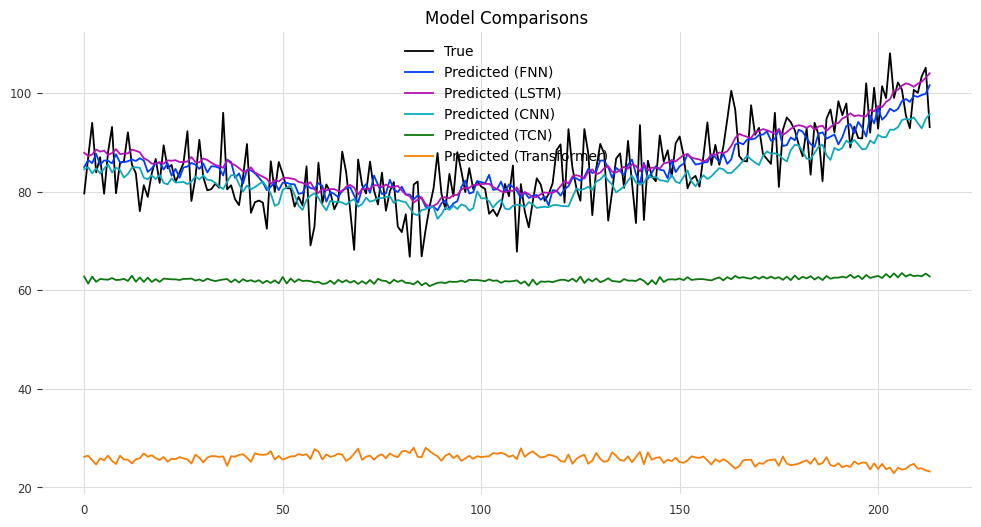

FNN MSE: 30.129
LSTM MSE: 29.946
CNN MSE: 37.866
TCN MSE: 579.660
Transformer MSE: 3578.198


In [ ]:
mse_scores = evaluate_and_plot(y_test, results, scaler)

In [ ]:
# # Main workflow
# filepath = "ercot_load_data.csv"  # Replace with your dataset file path
# n_steps = 30

# # Load and preprocess data
# X_train, X_test, y_train, y_test, scaler = load_and_preprocess_data(filepath, n_steps)

# # Train models and get predictions
# results = run_models(X_train, X_test, y_train, y_test, n_steps)

# # Evaluate and visualize results
# mse_scores = evaluate_and_plot(y_test, results, scaler)

# m4

In [ ]:
!pip install keras-tcn


In [8]:
df.head(1)

Air Dew Point  Air Temperature (OC)  Humidity %  \
Datetime                                                      
2000-01-01       0.229885              0.251429    0.361102   

            Atmospheric Pressure    Wind_U    Wind_V  
Datetime                                              
2000-01-01               0.54878  0.408046  0.493649

In [9]:
df.describe().transpose()

count      mean       std  min       25%       50%  \
Air Dew Point         210384.0  0.559075  0.217950  0.0  0.421456  0.559387   
Air Temperature (OC)  210384.0  0.469493  0.248789  0.0  0.262857  0.457143   
Humidity %            210384.0  0.494592  0.272234  0.0  0.269636  0.477162   
Atmospheric Pressure  210384.0  0.429602  0.235074  0.0  0.239837  0.414634   
Wind_U                210384.0  0.503815  0.200636  0.0  0.408046  0.474138   
Wind_V                210384.0  0.465460  0.170846  0.0  0.373412  0.493649   

                           75%  max  
Air Dew Point         0.727969  1.0  
Air Temperature (OC)  0.657143  1.0  
Humidity %            0.724470  1.0  
Atmospheric Pressure  0.597561  1.0  
Wind_U                0.640230  1.0  
Wind_V                0.493649  1.0

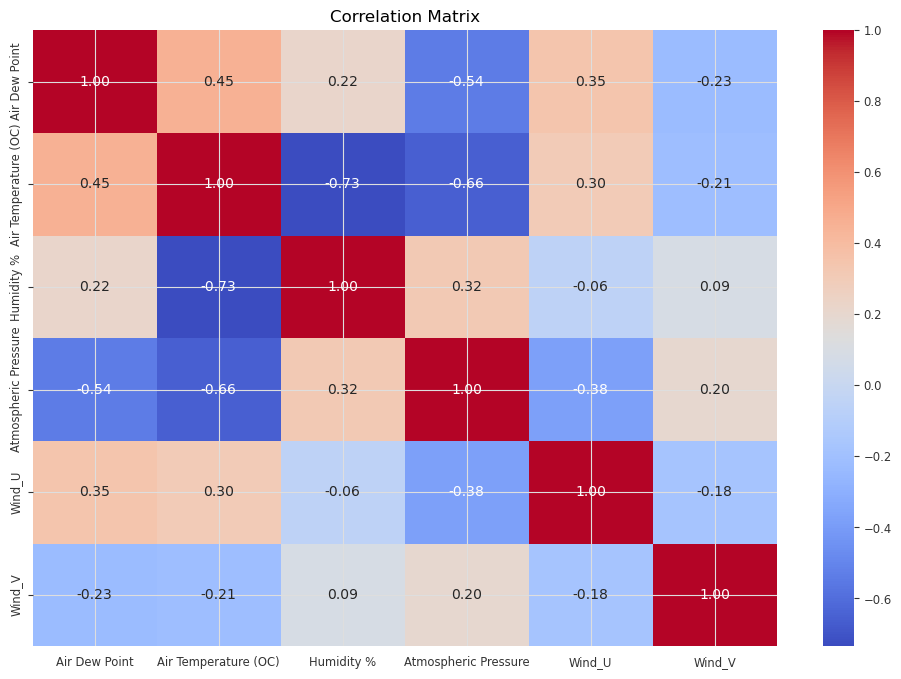

In [8]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numerical_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

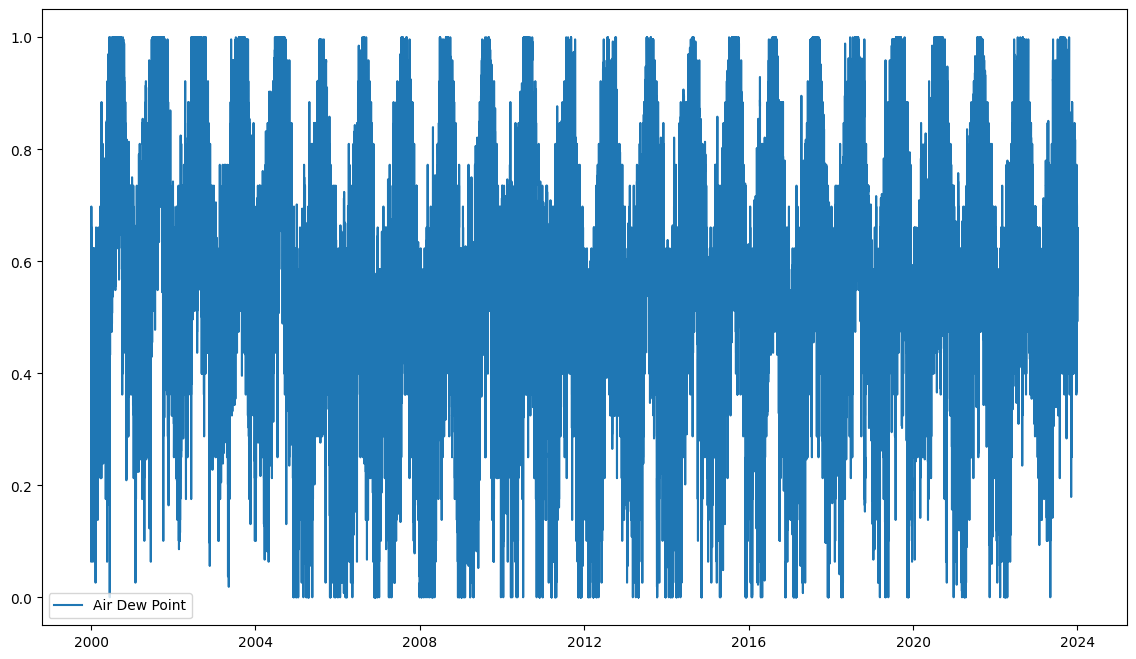

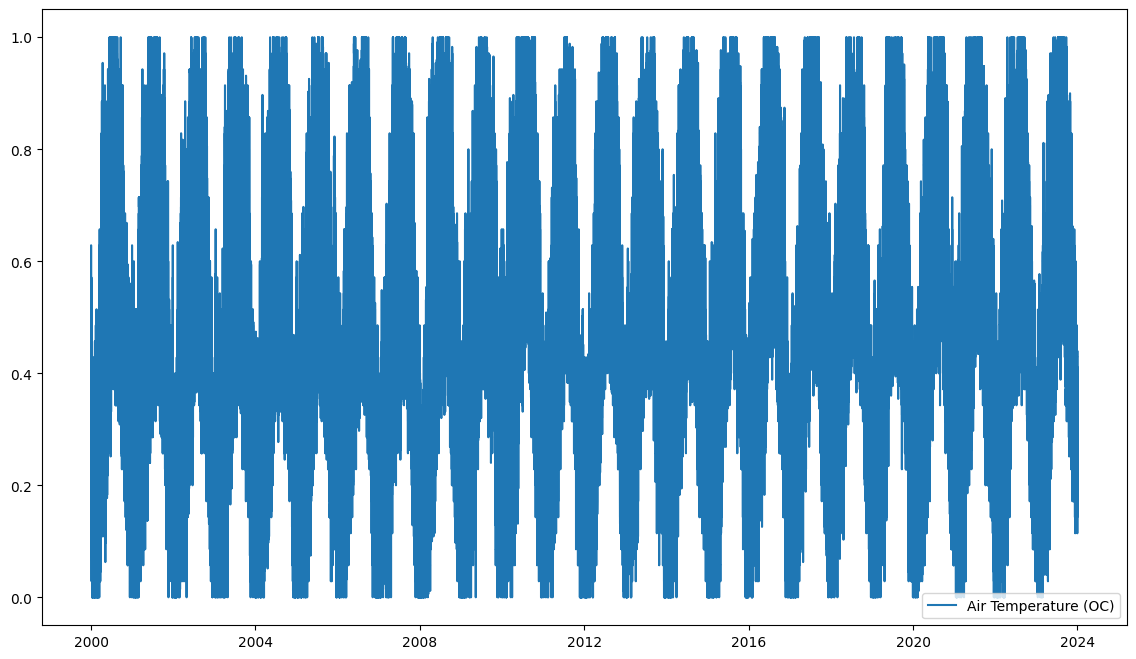

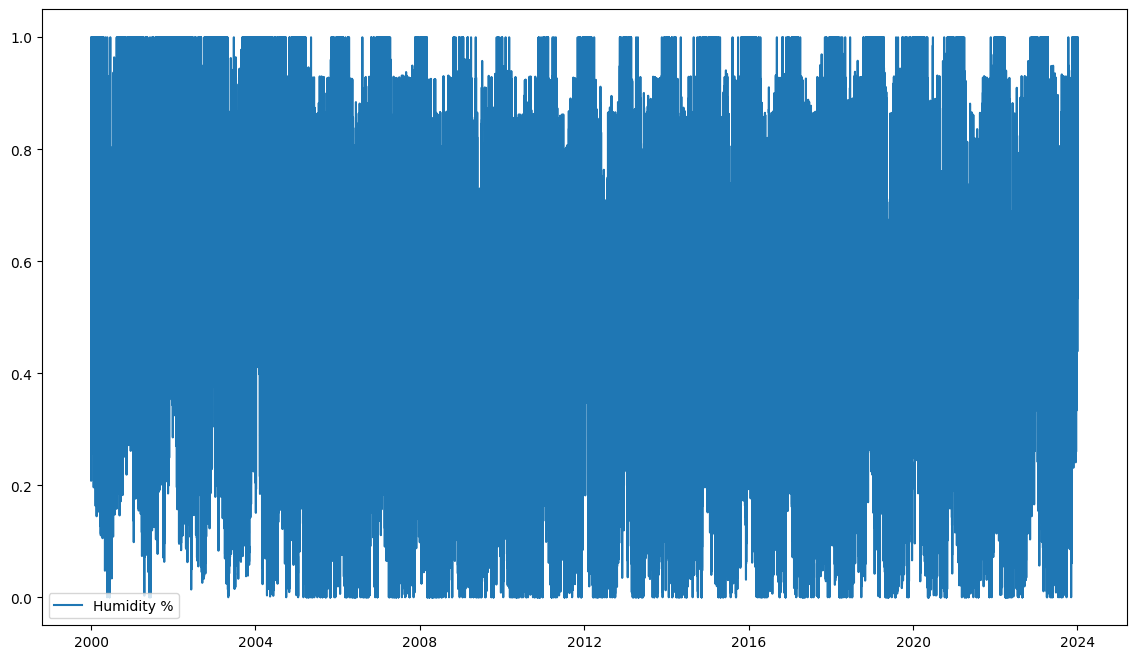

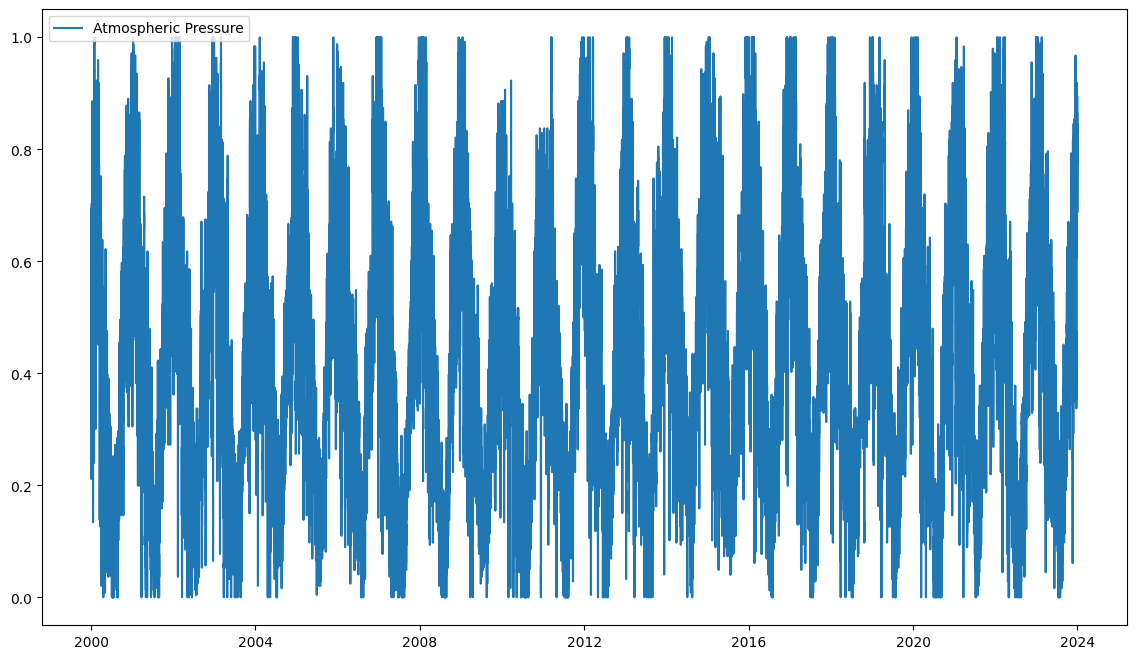

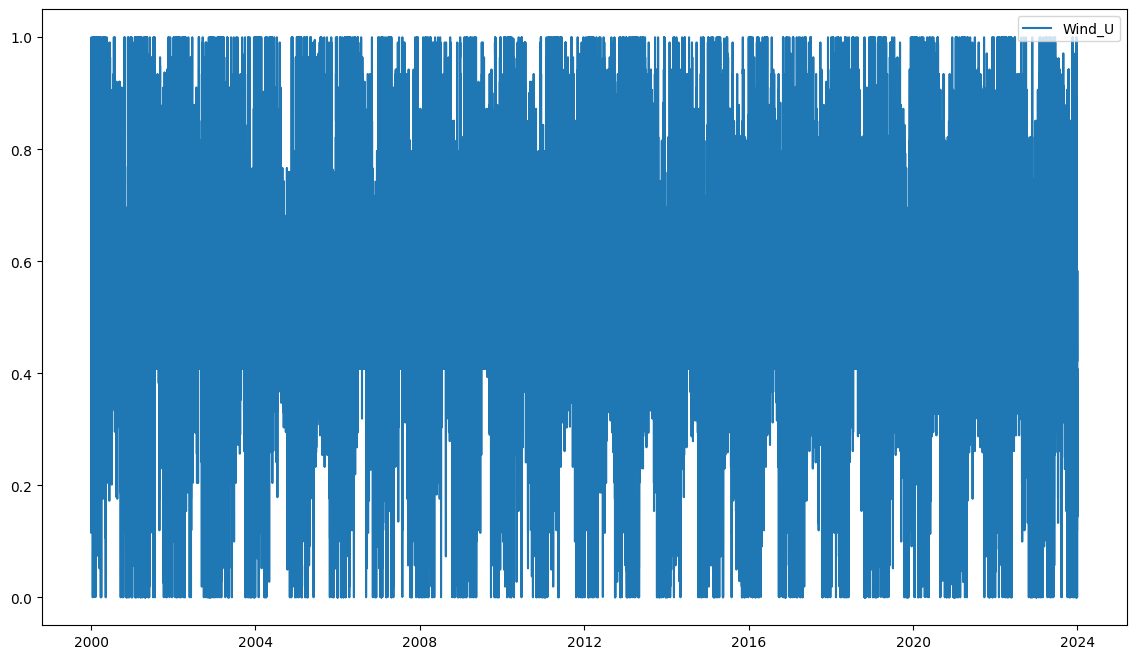

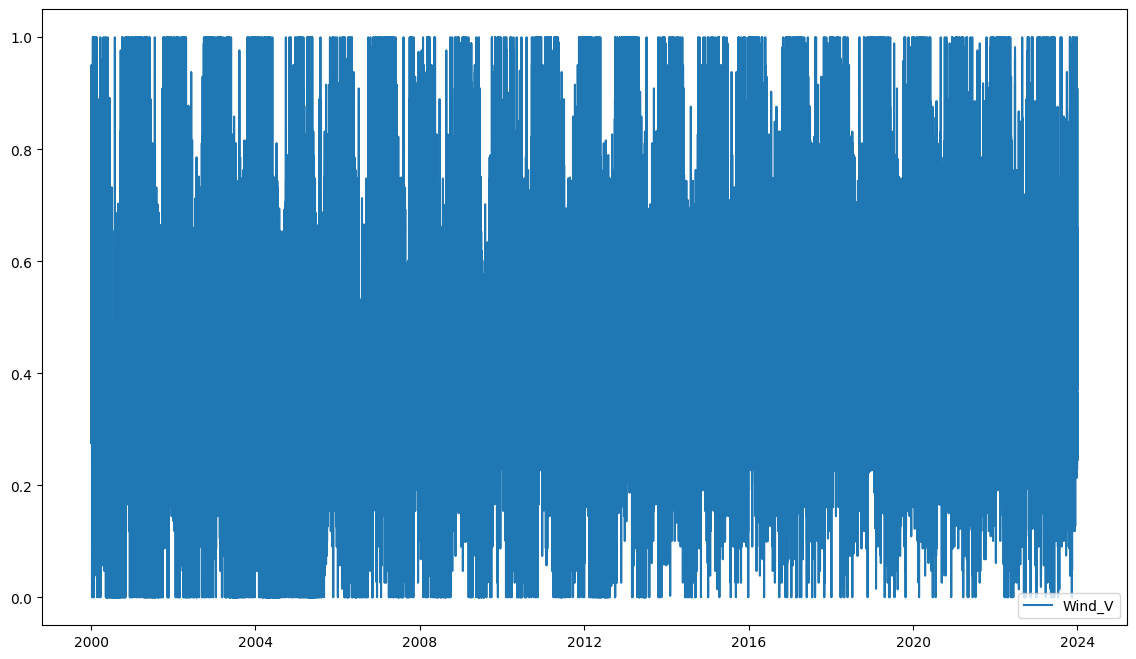

In [ ]:
for col in df.columns:
  plt.figure(figsize=(14,8))
  plt.plot(df[col], label=col)
  plt.legend()
  plt.show()


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length):
        X.append(data.iloc[i:i+seq_length][df.columns].values)
        y.append(data.iloc[i+seq_length:i+seq_length+pred_length][df.columns].values)
    return np.array(X), np.array(y)

seq_length = 24*7  # Number of time steps to look back
pred_length = 24  # Number of time steps to predict

X, y = create_sequences(df, seq_length, pred_length)


In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(168153, 168, 6) (42039, 168, 6) (168153, 24, 6) (42039, 24, 6)


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

In [13]:
from tensorflow.keras.layers import Reshape

def build_tcn_model(input_shape):
    model = Sequential()

    # Convolutional layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))

    # Output layer
    model.add(Dense(pred_length * 6))  # Output shape: (batch_size, 21)

    # Reshape the output to match the target shape (batch_size, 7, 3)
    model.add(Reshape((pred_length, 6)))  # Output shape: (batch_size, 7, 3)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return model

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_tcn_model(input_shape)
model.summary()

C:\Users\abood\miniconda3\envs\ml-env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 166, 64)             │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 83, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 81, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         655,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 144)                 │           9,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 24, 6)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 699,024 (2.67 MB)

 Trainable params: 699,024 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4204/4204 ━━━━━━━━━━━━━━━━━━━━ 111s 26ms/step - loss: 0.0341 - val_loss: 0.0180
Epoch 2/10
4204/4204 ━━━━━━━━━━━━━━━━━━━━ 103s 25ms/step - loss: 0.0188 - val_loss: 0.0185
Epoch 3/10
4204/4204 ━━━━━━━━━━━━━━━━━━━━ 147s 26ms/step - loss: 0.0176 - val_loss: 0.0189
Epoch 4/10
4204/4204 ━━━━━━━━━━━━━━━━━━━━ 136s 24ms/step - loss: 0.0172 - val_loss: 0.0190
Epoch 5/10
4204/4204 ━━━━━━━━━━━━━━━━━━━━ 142s 24ms/step - loss: 0.0167 - val_loss: 0.0203
Epoch 6/10
4204/4204 ━━━━━━━━━━━━━━━━━━━━ 146s 25ms/step - loss: 0.0165 - val_loss: 0.0195
Epoch 7/10
4204/4204 ━━━━━━━━━━━━━━━━━━━━ 138s 24ms/step - loss: 0.0163 - val_loss: 0.0192
Epoch 8/10
4204/4204 ━━━━━━━━━━━━━━━━━━━━ 141s 24ms/step - loss: 0.0161 - val_loss: 0.0190
Epoch 9/10
4204/4204 ━━━━━━━━━━━━━━━━━━━━ 101s 24ms/step - loss: 0.0159 - val_loss: 0.0198
Epoch 10/10
4204/4204 ━━━━━━━━━━━━━━━━━━━━ 144s 25ms/step - loss: 0.0158 - val_loss: 0.0202


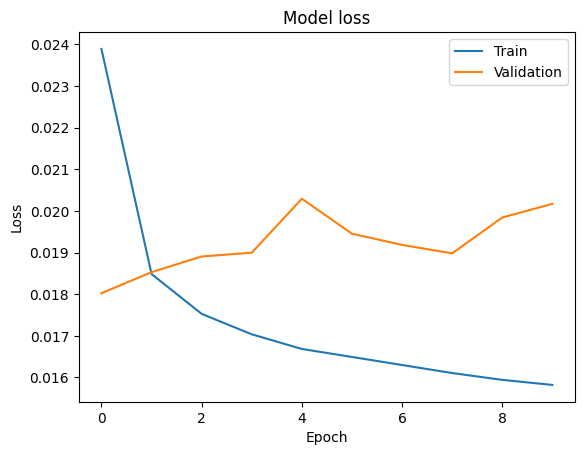

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [31]:
y_pred = model.predict(X_test)

# Reshape y_test and y_pred for metric calculation
y_test_reshaped = y_test.reshape(-1, 6)  # Shape: (batch_size * 7, 3)
y_pred_reshaped = y_pred.reshape(-1, 6)  # Shape: (batch_size * 7, 3)

# Calculate overall metrics
rmse = np.sqrt(mean_squared_error(y_test_reshaped, y_pred_reshaped))
mse = mean_squared_error(y_test_reshaped, y_pred_reshaped)
mae = mean_absolute_error(y_test_reshaped, y_pred_reshaped)
r2 = r2_score(y_test_reshaped, y_pred_reshaped)

print(f'Overall Metrics:')
print(f'RMSE: {rmse}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

# Individual metrics for each parameter
for i, param in enumerate(df.columns):
    # Calculate metrics for each parameter
    rmse_param = np.sqrt(mean_squared_error(y_test_reshaped[:, i], y_pred_reshaped[:, i]))
    mse_param = mean_squared_error(y_test_reshaped[:, i], y_pred_reshaped[:, i])
    mae_param = mean_absolute_error(y_test_reshaped[:, i], y_pred_reshaped[:, i])
    r2_param = r2_score(y_test_reshaped[:, i], y_pred_reshaped[:, i])

    # Print metrics for the parameter
    print(f'\n{param} Metrics:')
    print(f'RMSE: {rmse_param}')
    print(f'MSE: {mse_param}')
    print(f'MAE: {mae_param}')
    print(f'R²: {r2_param}')

1314/1314 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step
Overall Metrics:
RMSE: 0.12212885277532298
MSE: 0.014915456680216516
MAE: 0.09210416798775117
R²: 0.6572279043576419

Air Dew Point Metrics:
RMSE: 0.11862960139802693
MSE: 0.014072982327854755
MAE: 0.09287262100502638
R²: 0.7051469640911363

Air Temperature (OC) Metrics:
RMSE: 0.07966615895130036
MSE: 0.006346696882053855
MAE: 0.06306037025399638
R²: 0.8978695818219607

Humidity % Metrics:
RMSE: 0.13144086061564042
MSE: 0.01727669983938021
MAE: 0.10376080017691895
R²: 0.7669285831276705

Atmospheric Pressure Metrics:
RMSE: 0.09923200161954732
MSE: 0.009846990145421841
MAE: 0.07937474012276961
R²: 0.8223518137866728

Wind_U Metrics:
RMSE: 0.13992160543293775
MSE: 0.019578055666930716
MAE: 0.10552226037996831
R²: 0.5140225269273766

Wind_V Metrics:
RMSE: 0.14957043564707473
MSE: 0.02237131521965572
MAE: 0.10803421598729797
R²: 0.23704795639383636


<ipython-input-38-66033d0a4309>:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


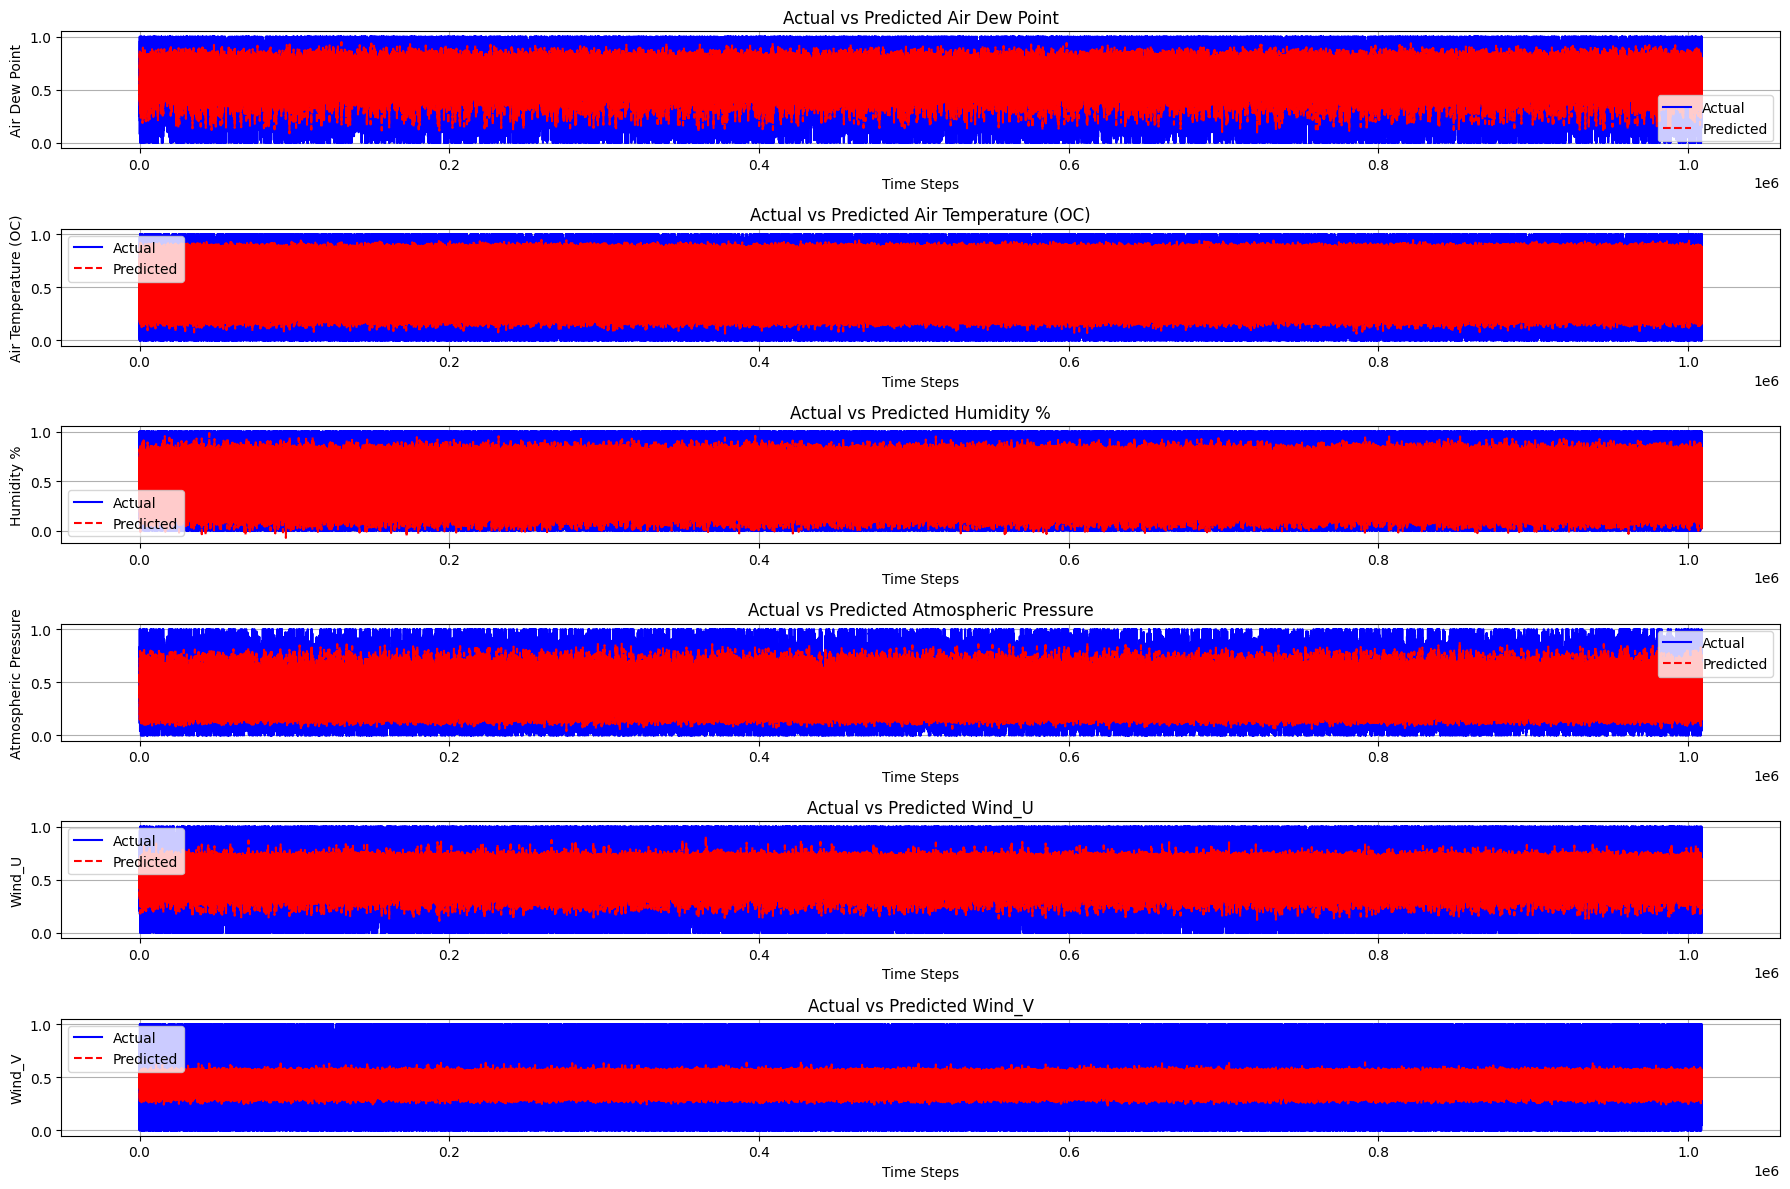

In [ ]:
target_names = df.columns
plt.figure(figsize=(18, 12))

for i, target in enumerate(target_names):
    plt.subplot(6, 1, i + 1)
    plt.plot(y_test_reshaped[:, i], label='Actual', color='blue')
    plt.plot(y_pred_reshaped[:, i], label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted {target}')
    plt.xlabel('Time Steps')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model.save('weather_forecasting_tcn_model.h5')


In [19]:
!pip install keras-tuner


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

   -------------------- ------------------- 1/2 [keras-tuner]
   ---------------------------------------- 2/2 [keras-tuner]



In [2]:
import tensorflow as tf

In [15]:
print("test")

test


In [16]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU detected and memory growth enabled.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected, training will run on CPU.")

No GPU detected, training will run on CPU.


In [17]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Name:", tf.config.list_physical_devices('GPU'))

Num GPUs Available: 0
GPU Name: []


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

In [20]:
import keras_tuner as kt

def build_tcn_model(hp):
    model = Sequential()

    # Tunable number of filters
    filters = hp.Int('filters', min_value=32, max_value=256, step=32)

    # Tunable kernel size
    kernel_size = hp.Int('kernel_size', min_value=2, max_value=5, step=1)

    # Tunable number of convolutional layers
    num_layers = hp.Int('num_layers', min_value=1, max_value=4, step=1)

    # Tunable dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)

    # Tunable learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Add convolutional layers
    for i in range(num_layers):
        model.add(Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation='relu',
            padding='same',
            input_shape=(X_train.shape[1], X_train.shape[2]) if i == 0 else None
        ))
        model.add(MaxPooling1D(pool_size=2))

    # Flatten and add dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))

    # Output layer
    model.add(Dense(pred_length * 6))
    model.add(Reshape((pred_length, 6)))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse'
    )

    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_tcn_model,
    objective='val_loss',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='tuner_results',
    project_name='tcn_weather_forecasting'
)

# Perform hyperparameter search
tuner.search(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=128,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Filters: {best_hps.get('filters')}
- Kernel Size: {best_hps.get('kernel_size')}
- Number of Layers: {best_hps.get('num_layers')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Reloading Tuner from tuner_results\tcn_weather_forecasting\tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
128               |256               |filters
2                 |4                 |kernel_size
3                 |2                 |num_layers
0.5               |0.2               |dropout_rate
0.0001            |0.001             |learning_rate


Epoch 1/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 63s 57ms/step - loss: 0.1255 - val_loss: 0.0266
Epoch 2/20
  76/1051 ━━━━━━━━━━━━━━━━━━━━ 46s 48ms/step - loss: 0.0343

KeyboardInterrupt: 

In [22]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt


pred_length = y_train.shape[1]
# -----------------------------

# Wrapper to pass input shape and pred_length
def build_tcn_model_wrapper(X_shape, pred_length):
    def build_tcn_model(hp):
        model = Sequential()

        filters = hp.Int('filters', 32, 256, step=32)
        kernel_size = hp.Int('kernel_size', 2, 5)
        num_layers = hp.Int('num_layers', 1, 4)
        dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
        learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

        for i in range(num_layers):
            model.add(Conv1D(
                filters=filters,
                kernel_size=kernel_size,
                activation='relu',
                padding='same',
                input_shape=X_shape if i == 0 else None
            ))
            model.add(MaxPooling1D(pool_size=2))

        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(64, activation='relu'))

        model.add(Dense(pred_length * 6))
        model.add(Reshape((pred_length, 6)))

        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        return model
    return build_tcn_model

# Build function with current shape
build_fn = build_tcn_model_wrapper(X_train.shape[1:], pred_length)

# Initialize the tuner
tuner = kt.RandomSearch(
    build_fn,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='tcn_weather_forecasting'
)

# Perform hyperparameter search
tuner.search(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=128,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

# Retrieve best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Filters: {best_hps.get('filters')}
- Kernel Size: {best_hps.get('kernel_size')}
- Number of Layers: {best_hps.get('num_layers')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Learning Rate: {best_hps.get('learning_rate')}
""")


Trial 10 Complete [00h 24m 20s]
val_loss: 0.013723544776439667

Best val_loss So Far: 0.011596441268920898
Total elapsed time: 04h 55m 09s

Best Hyperparameters:
- Filters: 32
- Kernel Size: 5
- Number of Layers: 4
- Dropout Rate: 0.30000000000000004
- Learning Rate: 0.001



Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.0913 - val_loss: 0.0210
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - loss: 0.0242 - val_loss: 0.0178
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.0211 - val_loss: 0.0162
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - loss: 0.0198 - val_loss: 0.0158
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - loss: 0.0189 - val_loss: 0.0154
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.0183 - val_loss: 0.0151
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - loss: 0.0178 - val_loss: 0.0149
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.0174 - val_loss: 0.0148
Epoch 9/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.0171 - val_loss: 0.0146
Epoch 10/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - loss: 0.0168 - val_loss: 0.0145
Epoch 11/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.0166 - val_loss: 0.0144
Epoch 12/20
263/263

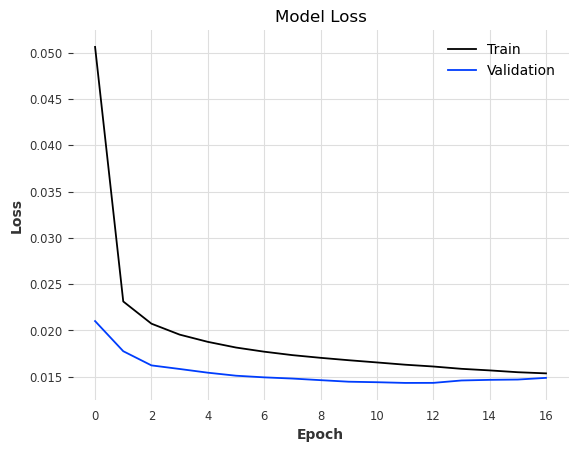

In [26]:
best_model = tuner.hypermodel.build(best_hps)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=512,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [25]:
best_model.summary()

AttributeError: 'RandomSearch' object has no attribute 'summary'

In [27]:
best_model.save('best_tcn_model_step1.h5')
print("Best model from Step 1 saved successfully.")

Best model from Step 1 saved successfully.


In [29]:
best_model.save("best_tcn_model.keras")

In [3]:
best_model = keras.models.load_model("best_tcn_model.keras")

C:\Users\abood\miniconda3\envs\ml-env\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


C:\Users\abood\AppData\Local\Temp\ipykernel_14172\3328855940.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\abood\miniconda3\envs\ml-env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


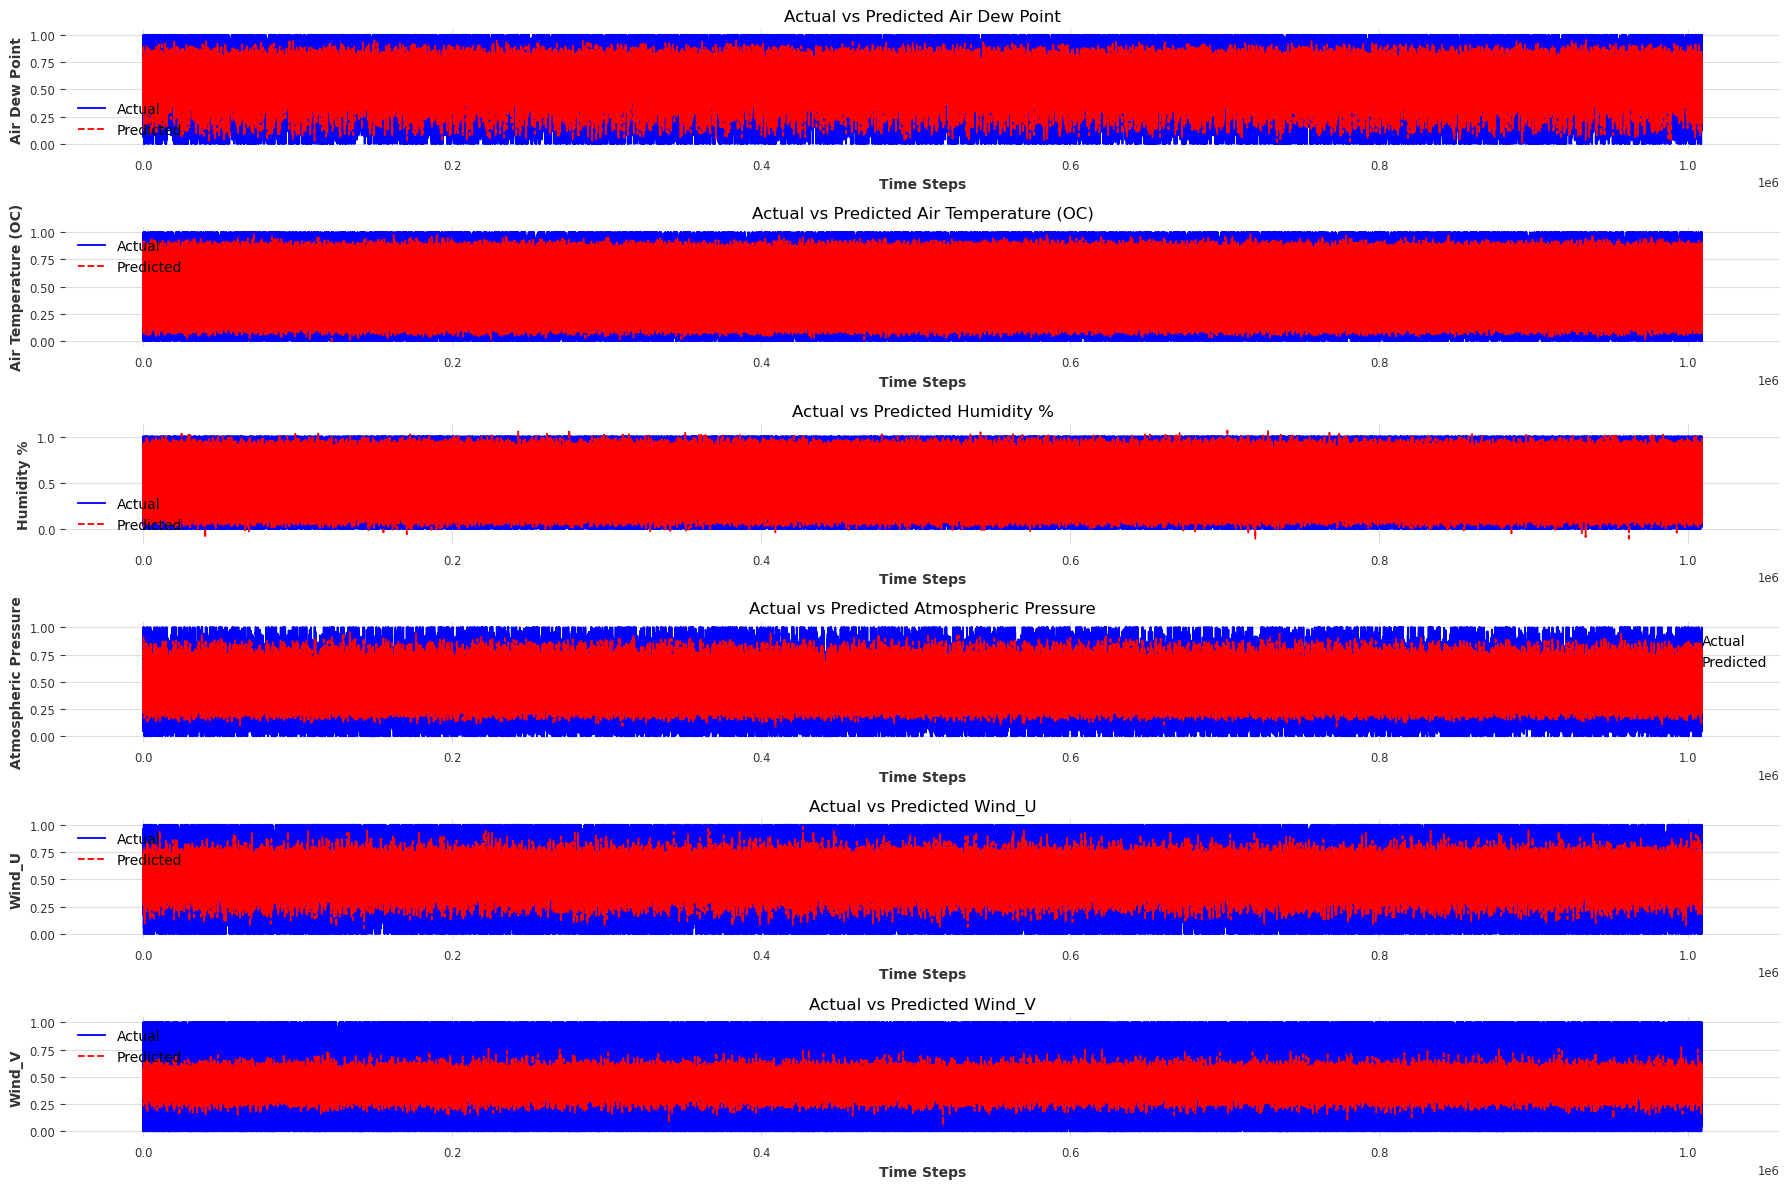

In [32]:
target_names = df.columns
plt.figure(figsize=(18, 12))

for i, target in enumerate(target_names):
    plt.subplot(6, 1, i + 1)
    plt.plot(y_test_reshaped[:, i], label='Actual', color='blue')
    plt.plot(y_pred_reshaped[:, i], label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted {target}')
    plt.xlabel('Time Steps')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
y_pred = best_model.predict(X_test)

y_test_reshaped = y_test.reshape(-1, 6)  # Shape: (num_samples * pred_length, 3)
y_pred_reshaped = y_pred.reshape(-1, 6)  # Shape: (num_samples * pred_length, 3)

1314/1314 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step


In [ ]:
# Plot actual vs predicted for each target variable
target_names = df.columns
colors = ['blue', 'green', 'red', 'yellow', 'black', 'purple']  # Colors for each target variable

plt.figure(figsize=(18, 12))

for i, target in enumerate(target_names):
    plt.subplot(6, 1, i + 1)

    # Plot actual values
    plt.plot(y_test_reshaped[:, i], label='Actual', color=colors[i], linewidth=2)

    # Plot predicted values
    plt.plot(y_pred_reshaped[:, i], label='Predicted', color='orange', linestyle='--', linewidth=2)

    # Add labels, title, and legend
    plt.title(f'Actual vs Predicted {target}', fontsize=14)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel(target, fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Customize the plot
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()

plt.show()

C:\Users\abood\AppData\Local\Temp\ipykernel_17612\714272784.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
